# Introduction to Graph Neural Nets with JAX/jraph

*Lisa Wang, DeepMind (wanglisa@deepmind.com), Nikola Jovanović, ETH Zurich (nikola.jovanovic@inf.ethz.ch)*

**Colab Runtime:**

If possible, please use a GPU hardware accelerator to run this colab. You can choose that under *Runtime > Change Runtime Type*.

**Prerequisites:**
* Some familiarity with [JAX](https://github.com/google/jax), you can refer to this [colab](https://colab.sandbox.google.com/github/google/jax/blob/master/docs/jax-101/01-jax-basics.ipynb) for an introduction to JAX.
* Neural network basics
* Graph theory basics (MIT Open Courseware [slides](https://ocw.mit.edu/courses/civil-and-environmental-engineering/1-022-introduction-to-network-models-fall-2018/lecture-notes/MIT1_022F18_lec2.pdf) by Amir Ajorlou)


We recommend watching the [Theoretical Foundations of Graph Neural Networks Lecture](https://www.youtube.com/watch?v=uF53xsT7mjc&) by Petar Veličković before working through this colab. The talk provides a theoretical introduction to Graph Neural Networks (GNNs), historical context and motivating examples.


**Outline:**
* [Fundamental Graph Concepts](#scrollTo=gsKA-syx_LUi)
* [Graph Prediction Tasks](#scrollTo=spQGRxhPN8Eo)
* [Intro to the jraph Library](#scrollTo=3C5YI9M0vwvb)
* [Graph Convolutional Network (GCN) Layer](#scrollTo=NZRMF2d-h2pd)
* [Build GCN Model with Multiple Layers](#scrollTo=lha8rbQ78l3S)
* [Node Classification with GCN on Karate Club Dataset](#scrollTo=Z5t7kw7SE_h4)
* [Graph Attention (GAT) Layer](#scrollTo=yg8g96NdBCK6)
* [Train GAT Model on Karate Club Dataset](#scrollTo=anfVGJwBe27v)
* [Graph Classification on MUTAG (Molecules)](#scrollTo=n5TxaTGzBkBa)
* [Link Prediction on CORA (Citation Network)](#scrollTo=OwVE88dTRC6V)
* [Bonus: Intro to Graph Adversarial Attacks](#scrollTo=35kbP8GZRFEm)


**Additional Resources:**

* Battaglia et al. (2018): [Relational inductive biases, deep learning, and graph networks](https://arxiv.org/pdf/1806.01261)

---

Some sections in this colab build on the [GraphNets Tutorial colab in pytorch](https://github.com/eemlcommunity/PracticalSessions2021/blob/main/graphnets/graphnets_tutorial.ipynb) by Nikola Jovanović.

We would like to thank Razvan Pascanu and Petar Veličković for their valuable input and feedback.

---
*Copyright 2022 by the Authors.*

*Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at https://www.apache.org/licenses/LICENSE-2.0*

*Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.*

## Setup: Install and Import libraries

In [ ]:
!pip install git+https://github.com/deepmind/jraph.git
!pip install flax
!pip install dm-haiku

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/deepmind/jraph.git to /tmp/pip-req-build-_y615xrt
  Running command git clone --filter=blob:none --quiet https://github.com/deepmind/jraph.git /tmp/pip-req-build-_y615xrt
  Resolved https://github.com/deepmind/jraph.git to commit 51f5990104f7374492f8f3ea1cbc47feb411c69c
  Preparing metadata (setup.py) ... done
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Imports
%matplotlib inline
import functools
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import jax.tree_util as tree
import jraph
import flax
import haiku as hk
import optax
import pickle
import numpy as onp
import networkx as nx
from typing import Any, Callable, Dict, List, Optional, Tuple

## Fundamental Graph Concepts
A graph consists of a set of nodes and a set of edges, where edges form connections between nodes.

More formally, a graph is defined as $ \mathcal{G} = (\mathcal{V}, \mathcal{E})$ where $\mathcal{V}$ is the set of vertices / nodes, and $\mathcal{E}$ is the set of edges.

In an **undirected** graph, each edge is an unordered pair of two nodes $ \in \mathcal{V}$. E.g. a friend network can be represented as an undirected graph, assuming that the relationship "*A is friends with B*" implies "*B is friends with A*".

In a **directed** graph, each edge is an ordered pair of nodes $ \in \mathcal{V}$. E.g. a citation network would be best represented with a directed graph, since the relationship "*A cites B*" does not imply "*B cites A*".

The **degree** of a node is defined as the number of edges incident on it, i.e. the sum of incoming and outgoing edges for that node.

The **in-degree** is the sum of incoming edges only, and the **out-degree** is the sum of outgoing edges only.

There are several ways to represent $\mathcal{E}$:
1. As a **list of edges**: a list of pairs $(u,v)$, where $(u,v)$ means that there is an edge going from node $u$ to node $v$.
2. As an **adjacency matrix**: a binary square matrix $A$ of size $|\mathcal{V}| \times |\mathcal{V}|$, where $A_{u,v}=1$ iff there is a connection between nodes $u$ and $v$.
3. As an **adjacency list**: An array of $|\mathcal{V}|$ unordered lists, where the $i$th list corresponds to the $i$th node, and contains all the nodes directly connected to node $i$.


Example: Below is a directed graph with four nodes and five edges.

<image src="https://storage.googleapis.com/dm-educational/assets/graph-nets/toy_graph.png" width="400px">

The arrows on the edges indicate the direction of each edge, e.g. there is an edge going from node 0 to node 1. Between node 0 and node 3, there are two edges: one going from node 0 to node 3 and one from node 3 to node 0.

Node 0 has out-degree of 2, since it has two outgoing edges, and an in-degree of 2, since it has two incoming edges.

The list of edges is:
$$[(0, 1), (0, 3), (1, 2), (2, 0), (3, 0)]$$

As adjacency matrix:

$$\begin{array}{l|llll}
 source \setminus dest    & n_0 & n_1 & n_2 & n_3 \\ \hline
n_0 & 0    & 1    & 0    & 1    \\
n_1 & 0    & 0    & 1    & 0    \\
n_2 & 1    & 0    & 0    & 0    \\
n_3 & 1    & 0    & 0    & 0
\end{array}$$

As adjacency list:

$$[\{1, 3\}, \{2\}, \{0\}, \{0\}]$$



## Graph Prediction Tasks
What are the kinds of problems we want to solve on graphs?


The tasks fall into roughly three categories:

1. **Node Classification**: E.g. what is the topic of a paper given a citation network of papers?
2. **Link Prediction / Edge Classification**: E.g. are two people in a social network friends?
3. **Graph Classification**: E.g. is this protein molecule (represented as a graph) likely going to be effective?

<image src="https://storage.googleapis.com/dm-educational/assets/graph-nets/graph_tasks.png" width="700px">

*The three main graph learning tasks. Image source: Petar Veličković.*

Which examples of graph prediction tasks come to your mind? Which task types do they correspond to?

We will create and train models on all three task types in this tutorial.


# Intro to the jraph Library

In the following sections, we will learn how to represent graphs and build GNNs in Python. We will use
[jraph](https://github.com/deepmind/jraph), a lightweight library for working with GNNs in [JAX](https://github.com/google/jax).

## Representing a graph in jraph

In jraph, a graph is represented with a `GraphsTuple` object. In addition to defining the graph structure of nodes and edges, you can also store node features, edge features and global graph features in a `GraphsTuple`.

In the `GraphsTuple`, edges are represented in two aligned arrays of node indices: senders (source nodes) and receivers (destinaton nodes).
Each index corresponds to one edge, e.g. edge `i` goes from `senders[i]` to `receivers[i]`.

You can even store multiple graphs in one `GraphsTuple` object.

We will start with creating a simple directed graph with 4 nodes and 5 edges. We will also add toy features to the nodes, using `2*node_index` as the feature.

We will later use this toy graph in the GCN demo.



In [ ]:
def build_toy_graph() -> jraph.GraphsTuple:
  """Define a four node graph, each node has a scalar as its feature."""

  # Nodes are defined implicitly by their features.
  # We will add four nodes, each with a feature, e.g.
  # node 0 has feature [0.],
  # node 1 has featre [2.] etc.
  # len(node_features) is the number of nodes.
  node_features = jnp.array([[0.], [2.], [4.], [6.]])

  # We will now specify 5 directed edges connecting the nodes we defined above.
  # We define this with `senders` (source node indices) and `receivers`
  # (destination node indices).
  # For example, to add an edge from node 0 to node 1, we append 0 to senders,
  # and 1 to receivers.
  # We can do the same for all 5 edges:
  # 0 -> 1
  # 1 -> 2
  # 2 -> 0
  # 3 -> 0
  # 0 -> 3
  senders = jnp.array([0, 1, 2, 3, 0])
  receivers = jnp.array([1, 2, 0, 0, 3])

  # You can optionally add edge attributes to the 5 edges.
  edges = jnp.array([[5.], [6.], [7.], [8.], [8.]])

  # We then save the number of nodes and the number of edges.
  # This information is used to make running GNNs over multiple graphs
  # in a GraphsTuple possible.
  n_node = jnp.array([4])
  n_edge = jnp.array([5])

  # Optionally you can add `global` information, such as a graph label.
  global_context = jnp.array([[1]]) # Same feature dims as nodes and edges.
  graph = jraph.GraphsTuple(
      nodes=node_features,
      edges=edges,
      senders=senders,
      receivers=receivers,
      n_node=n_node,
      n_edge=n_edge,
      globals=global_context
      )
  return graph

In [ ]:
graph = build_toy_graph()

## Inspecting the GraphsTuple


In [ ]:
# Number of nodes
# Note that `n_node` returns an array. The length of `n_node` corresponds to
# the number of graphs stored in one `GraphsTuple`.
# In this case, we only have one graph, so n_node has length 1.
graph.n_node

Array([4], dtype=int32)

In [ ]:
# Number of edges
graph.n_edge

Array([5], dtype=int32)

In [ ]:
# Node features
graph.nodes

Array([[0.],
       [2.],
       [4.],
       [6.]], dtype=float32)

In [ ]:
# Edge features
graph.edges

Array([[5.],
       [6.],
       [7.],
       [8.],
       [8.]], dtype=float32)

In [ ]:
# Edges
graph.senders

Array([0, 1, 2, 3, 0], dtype=int32)

In [ ]:
graph.receivers

Array([1, 2, 0, 0, 3], dtype=int32)

In [ ]:
# Graph-level features
graph.globals

Array([[1]], dtype=int32)

## Visualizing the Graph
To visualize the graph structure of the graph we created above, we will use the [`networkx`](networkx.org) library because it already has functions for drawing graphs.

We first convert the `jraph.GraphsTuple` to a `networkx.DiGraph`.

In [ ]:
def convert_jraph_to_networkx_graph(jraph_graph: jraph.GraphsTuple) -> nx.Graph:
  nodes, edges, receivers, senders, _, _, _ = jraph_graph
  nx_graph = nx.DiGraph()
  if nodes is None:
    for n in range(jraph_graph.n_node[0]):
      nx_graph.add_node(n)
  else:
    for n in range(jraph_graph.n_node[0]):
      nx_graph.add_node(n, node_feature=nodes[n])
  if edges is None:
    for e in range(jraph_graph.n_edge[0]):
      nx_graph.add_edge(int(senders[e]), int(receivers[e]))
  else:
    for e in range(jraph_graph.n_edge[0]):
      nx_graph.add_edge(
          int(senders[e]), int(receivers[e]), edge_feature=edges[e])
  return nx_graph


def draw_jraph_graph_structure(jraph_graph: jraph.GraphsTuple) -> None:
  nx_graph = convert_jraph_to_networkx_graph(jraph_graph)
  pos = nx.spring_layout(nx_graph)
  nx.draw(
      nx_graph, pos=pos, with_labels=True, node_size=500, font_color='yellow')

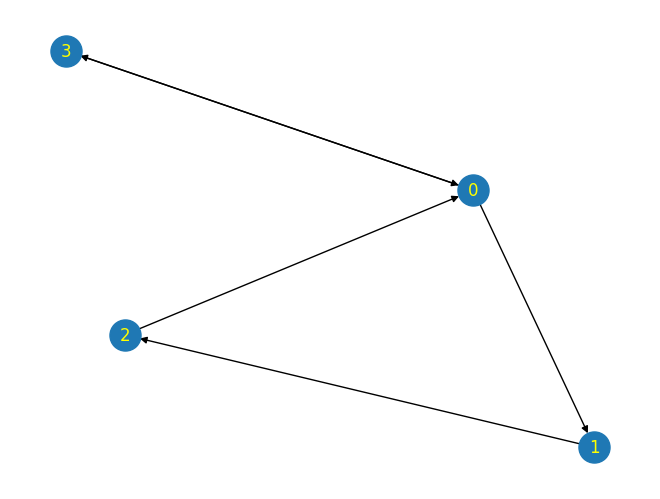

In [ ]:
draw_jraph_graph_structure(graph)

# Graph Convolutional Network (GCN) Layer
Now let's implement our first graph network!

The graph convolutional network, introduced by by Kipf et al. (2017) in https://arxiv.org/abs/1609.02907, is one of the basic graph network architectures. We will build its core building block, the graph convolutional layer.

In a convolutional neural network (CNN), a convolutional filter (e.g. 3x3) is applied repeatedly to different parts of a larger input (e.g. 64x64) by striding across the input.

In a GCN, a convolution filter is applied to the neighbourhoods around a node in a graph.

However, there are also some differences to point out:
In contrast to the CNN filter, the neighbourhoods in a GCN can be of different sizes, and there is no ordering of inputs. To see that, note that the CNN filter performs a weighted sum aggregation over the inputs with learnable weights, where each filter input has its own weight. In the GCN, the same weight is applied to all neighbours and the aggregation function is not learned. In other words, in a GCN, each neighbor contributes equally. This is why the CNN filter is not order-invariant, but the GCN filter is.


<image src="https://storage.googleapis.com/dm-educational/assets/graph-nets/cnn_vs_gnn.png" width="400px">

Comparison of CNN and GCN filters.
Image source: https://arxiv.org/pdf/1901.00596.pdf

More specifically, the GCN layer performs two steps:

1. _Compute messages / update node features_: Create a feature vector $\vec{h}_n$ for each node $n$ (e.g. with an MLP). This is going to be the message that this node will pass to neighboring nodes.
2. _Message-passing / aggregate node features_: For each node, calculate a new feature vector $\vec{h}'_n$ based on the messages (features) from the nodes in its neighborhood. In a directed graph, only nodes from incoming edges are counted as neighbors. The image below shows this aggregation step. There are multiple options for aggregation in a GCN, e.g. taking the mean, the sum, the min or max. (Later in this tutorial, we will also see how we can make the aggregation function dependent on the node features by adding an attention mechanism in the Graph Attention Network.)

<image src="https://storage.googleapis.com/dm-educational/assets/graph-nets/graph_conv.png" width="500px">

*\"A generic overview of a graph convolution operation, highlighting the relevant information for deriving the next-level features for every node in the graph.\"* Image source: Petar Veličković (https://github.com/PetarV-/TikZ)


#### Simple GCN Layer

In [ ]:
def apply_simplified_gcn(graph: jraph.GraphsTuple) -> jraph.GraphsTuple:
  # Unpack GraphsTuple
  nodes, _, receivers, senders, _, _, _ = graph

  # 1. Update node features
  # For simplicity, we will first use an identify function here, and replace it
  # with a trainable MLP block later.
  update_node_fn = lambda nodes: nodes
  nodes = update_node_fn(nodes)

  # 2. Aggregate node features over nodes in neighborhood
  # Equivalent to jnp.sum(n_node), but jittable
  total_num_nodes = tree.tree_leaves(nodes)[0].shape[0]
  aggregate_nodes_fn = jax.ops.segment_sum

  # Compute new node features by aggregating messages from neighboring nodes
  nodes = tree.tree_map(lambda x: aggregate_nodes_fn(x[senders], receivers,
                                        total_num_nodes), nodes)
  out_graph = graph._replace(nodes=nodes)
  return out_graph

We can now run the graph convolution on our toy graph from before.

In [ ]:
graph = build_toy_graph()

Here is the visualized graph.

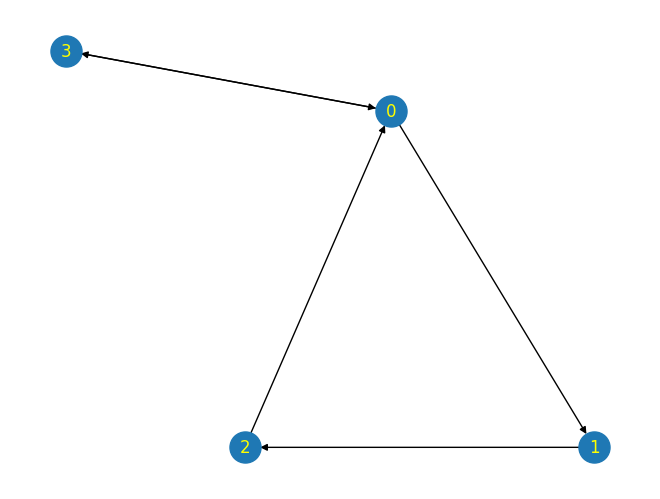

In [ ]:
draw_jraph_graph_structure(graph)

In [ ]:
out_graph = apply_simplified_gcn(graph)

Since we used the identity function for updating nodes and sum aggregation, we can verify the results pretty easily. As a reminder, in this toy graph, the node features are the same as the node index.

Node 0: sum of features from node 2 and node 3 $\rightarrow$ 10.

Node 1: sum of features from node 0 $\rightarrow$ 0.

Node 2: sum of features from node 1 $\rightarrow$ 2.

Node 3: sum of features from node 0 $\rightarrow$ 0.

In [ ]:
out_graph.nodes

Array([[10.],
       [ 0.],
       [ 2.],
       [ 0.]], dtype=float32)

#### Add Trainable Parameters to GCN layer
So far our graph convolution operation doesn't have any learnable parameters.
Let's add an MLP block to the update function to make it trainable.

In [ ]:
class MLP(hk.Module):
  def __init__(self, features: jnp.ndarray):
    super().__init__()
    self.features = features

  def __call__(self, x: jnp.ndarray) -> jnp.ndarray:
    layers = []
    for feat in self.features[:-1]:
      layers.append(hk.Linear(feat))
      layers.append(jax.nn.relu)
    layers.append(hk.Linear(self.features[-1]))

    mlp = hk.Sequential(layers)
    return mlp(x)

# Use MLP block to define the update node function
update_node_fn = lambda x: MLP(features=[8, 4])(x)

#### Check outputs of `update_node_fn` with MLP Block

In [ ]:
graph = build_toy_graph()

In [ ]:
update_node_module = hk.without_apply_rng(hk.transform(update_node_fn))
params = update_node_module.init(jax.random.PRNGKey(42), graph.nodes)
out = update_node_module.apply(params, graph.nodes)

As output, we expect the updated node features. We should see one array of dim 4 for each of the 4 nodes, which is the result of applying a single MLP block to the features of each node individually.

In [ ]:
out

Array([[ 0.        ,  0.        ,  0.        ,  0.        ],
       [-0.14526582,  0.3303816 , -0.50791126, -0.643716  ],
       [-0.29053164,  0.6607632 , -1.0158225 , -1.287432  ],
       [-0.4357974 ,  0.99114484, -1.5237337 , -1.931148  ]],      dtype=float32)

#### Add Self-Edges (Edges connecting a node to itself)
For each node, add an edge of the node onto itself. This way, nodes will include themselves in the aggregation step.

In [ ]:
def add_self_edges_fn(receivers: jnp.ndarray, senders: jnp.ndarray,
                      total_num_nodes: int) -> Tuple[jnp.ndarray, jnp.ndarray]:
  """Adds self edges. Assumes self edges are not in the graph yet."""
  receivers = jnp.concatenate((receivers, jnp.arange(total_num_nodes)), axis=0)
  senders = jnp.concatenate((senders, jnp.arange(total_num_nodes)), axis=0)
  return receivers, senders

#### Add Symmetric Normalization

Note that the nodes may have different numbers of neighbors / degrees.
This could lead to instabilities during neural network training, e.g. exploding or vanishing gradients. To address that, normalization is a commonly used method. In this case, we will normalize by node degrees.

As a first attempt, we could count the number of incoming edges (including self-edge) and divide by that value.

More formally, let $A$ be the adjacency matrix defining the edges of the graph.

Then we define the degree matrix $D$ as a diagonal matrix with $D_{ii} = \sum_jA_{ij}$ (the degree of node $i$)


Now we can normalize $AH$ by dividing it by the node degrees:
$${D}^{-1}AH$$

To take both the in and out degrees into account, we can use symmetric normalization, which is also what Kipf and Welling proposed in their [paper](https://arxiv.org/abs/1609.02907):
$$D^{-\frac{1}{2}}AD^{-\frac{1}{2}}H$$





#### General GCN Layer
Now we can write a more general and configurable version of the Graph Convolution layer, allowing the caller to specify:

*   **`update_node_fn`**: Function to use to update node features (e.g. the MLP block version we just implemented)
*   **`aggregate_nodes_fn`**: Aggregation function to use to aggregate messages from neighbourhood.
*  **`add_self_edges`**: Whether to add self edges for aggregation step.
* **`symmetric_normalization`**: Whether to add symmetric normalization.



In [ ]:
# Adapted from https://github.com/deepmind/jraph/blob/master/jraph/_src/models.py#L506
def GraphConvolution(update_node_fn: Callable,
                     aggregate_nodes_fn: Callable = jax.ops.segment_sum,
                     add_self_edges: bool = False,
                     symmetric_normalization: bool = True) -> Callable:
  """Returns a method that applies a Graph Convolution layer.

  Graph Convolutional layer as in https://arxiv.org/abs/1609.02907,
  NOTE: This implementation does not add an activation after aggregation.
  If you are stacking layers, you may want to add an activation between
  each layer.
  Args:
    update_node_fn: function used to update the nodes. In the paper a single
      layer MLP is used.
    aggregate_nodes_fn: function used to aggregates the sender nodes.
    add_self_edges: whether to add self edges to nodes in the graph as in the
      paper definition of GCN. Defaults to False.
    symmetric_normalization: whether to use symmetric normalization. Defaults to
      True.

  Returns:
    A method that applies a Graph Convolution layer.
  """

  def _ApplyGCN(graph: jraph.GraphsTuple) -> jraph.GraphsTuple:
    """Applies a Graph Convolution layer."""
    nodes, _, receivers, senders, _, _, _ = graph

    # First pass nodes through the node updater.
    nodes = update_node_fn(nodes)
    # Equivalent to jnp.sum(n_node), but jittable
    total_num_nodes = tree.tree_leaves(nodes)[0].shape[0]
    if add_self_edges:
      # We add self edges to the senders and receivers so that each node
      # includes itself in aggregation.
      # In principle, a `GraphsTuple` should partition by n_edge, but in
      # this case it is not required since a GCN is agnostic to whether
      # the `GraphsTuple` is a batch of graphs or a single large graph.
      conv_receivers, conv_senders = add_self_edges_fn(receivers, senders,
                                                       total_num_nodes)
    else:
      conv_senders = senders
      conv_receivers = receivers

    # pylint: disable=g-long-lambda
    if symmetric_normalization:
      # Calculate the normalization values.
      count_edges = lambda x: jax.ops.segment_sum(
          jnp.ones_like(conv_senders), x, total_num_nodes)
      sender_degree = count_edges(conv_senders)
      receiver_degree = count_edges(conv_receivers)

      # Pre normalize by sqrt sender degree.
      # Avoid dividing by 0 by taking maximum of (degree, 1).
      nodes = tree.tree_map(
          lambda x: x * jax.lax.rsqrt(jnp.maximum(sender_degree, 1.0))[:, None],
          nodes,
      )
      # Aggregate the pre-normalized nodes.
      nodes = tree.tree_map(
          lambda x: aggregate_nodes_fn(x[conv_senders], conv_receivers,
                                       total_num_nodes), nodes)
      # Post normalize by sqrt receiver degree.
      # Avoid dividing by 0 by taking maximum of (degree, 1).
      nodes = tree.tree_map(
          lambda x:
          (x * jax.lax.rsqrt(jnp.maximum(receiver_degree, 1.0))[:, None]),
          nodes,
      )
    else:
      nodes = tree.tree_map(
          lambda x: aggregate_nodes_fn(x[conv_senders], conv_receivers,
                                       total_num_nodes), nodes)
    # pylint: enable=g-long-lambda
    return graph._replace(nodes=nodes)

  return _ApplyGCN

#### Test General GCN Layer

In [ ]:
gcn_layer = GraphConvolution(
    update_node_fn=lambda n: MLP(features=[8, 4])(n),
    aggregate_nodes_fn=jax.ops.segment_sum,
    add_self_edges=True,
    symmetric_normalization=True
)

In [ ]:
graph = build_toy_graph()
network = hk.without_apply_rng(hk.transform(gcn_layer))
params = network.init(jax.random.PRNGKey(42), graph)
out_graph = network.apply(params, graph)
out_graph.nodes

Array([[-0.29652256,  0.6743886 , -1.0367694 , -1.3139795 ],
       [-0.07263289,  0.16519076, -0.25395557, -0.32185793],
       [-0.21789868,  0.4955723 , -0.76186675, -0.9655737 ],
       [-0.21789865,  0.49557233, -0.7618667 , -0.96557385]],      dtype=float32)

#### Build GCN Model with Multiple Layers
With a single GCN layer, a node's representation after the GCN layer is only
influenced by its direct neighbourhood. However, we may want to consider larger neighbourhoods, i.e. more than just 1 hop away. To achieve that, we can stack
multiple GCN layers, similar to how stacking CNN layers expands the input region.

We will define a network with three GCN layers:

In [ ]:
def gcn(graph: jraph.GraphsTuple) -> jraph.GraphsTuple:
  """Defines a graph neural network with 3 GCN layers.
  Args:
    graph: GraphsTuple the network processes.

  Returns:
    output graph with updated node values.
  """
  gn = GraphConvolution(
      update_node_fn=lambda n: jax.nn.relu(hk.Linear(8)(n)),
      add_self_edges=True)
  graph = gn(graph)

  gn = GraphConvolution(
      update_node_fn=lambda n: jax.nn.relu(hk.Linear(4)(n)),
      add_self_edges=True)
  graph = gn(graph)

  gn = GraphConvolution(
      update_node_fn=hk.Linear(2))
  graph = gn(graph)
  return graph

In [ ]:
graph = build_toy_graph()
network = hk.without_apply_rng(hk.transform(gcn))
params = network.init(jax.random.PRNGKey(42), graph)
out_graph = network.apply(params, graph)
out_graph.nodes

Array([[-0.32386124,  0.10707336],
       [-0.23884147,  0.07896456],
       [-0.19206831,  0.06350066],
       [-0.23884147,  0.07896456]], dtype=float32)

#### Node Classification with GCN on Karate Club Dataset

Time to try out our GCN on our first graph prediction task!


#### Zachary's Karate Club Dataset

[Zachary's karate club](https://en.wikipedia.org/wiki/Zachary%27s_karate_club) is a small dataset commonly used as an example for a social graph. It's great for demo purposes, as it's easy to visualize and quick to train a model on it.

A node represents a student or instructor in the club. An edge means that those two people have interacted outside of the class. There are two instructors in the club.

Each student is assigned to one of two instructors.

#### Optimizing the GCN on the Karate Club Node Classification Task

The task is to predict the assignment of students to instructors, given the social graph and only knowing the assignment of two nodes (the two instructors) a priori.

In other words, out of the 34 nodes, only two nodes are labeled, and we are trying to optimize the assignment of the other 32 nodes, by **maximizing the log-likelihood of the two known node assignments**.

We will compute the accuracy of our node assignments by comparing to the ground-truth assignments. **Note that the ground-truth for the 32 student nodes is not used in the loss function itself.**

Let's load the dataset:

In [ ]:
"""Zachary's karate club example.
From https://github.com/deepmind/jraph/blob/master/jraph/examples/zacharys_karate_club.py.
Here we train a graph neural network to process Zachary's karate club.
https://en.wikipedia.org/wiki/Zachary%27s_karate_club
Zachary's karate club is used in the literature as an example of a social graph.
Here we use a graphnet to optimize the assignments of the students in the
karate club to two distinct karate instructors (Mr. Hi and John A).
"""

def get_zacharys_karate_club() -> jraph.GraphsTuple:
  """Returns GraphsTuple representing Zachary's karate club."""
  social_graph = [
      (1, 0), (2, 0), (2, 1), (3, 0), (3, 1), (3, 2),
      (4, 0), (5, 0), (6, 0), (6, 4), (6, 5), (7, 0), (7, 1),
      (7, 2), (7, 3), (8, 0), (8, 2), (9, 2), (10, 0), (10, 4),
      (10, 5), (11, 0), (12, 0), (12, 3), (13, 0), (13, 1), (13, 2),
      (13, 3), (16, 5), (16, 6), (17, 0), (17, 1), (19, 0), (19, 1),
      (21, 0), (21, 1), (25, 23), (25, 24), (27, 2), (27, 23),
      (27, 24), (28, 2), (29, 23), (29, 26), (30, 1), (30, 8),
      (31, 0), (31, 24), (31, 25), (31, 28), (32, 2), (32, 8),
      (32, 14), (32, 15), (32, 18), (32, 20), (32, 22), (32, 23),
      (32, 29), (32, 30), (32, 31), (33, 8), (33, 9), (33, 13),
      (33, 14), (33, 15), (33, 18), (33, 19), (33, 20), (33, 22),
      (33, 23), (33, 26), (33, 27), (33, 28), (33, 29), (33, 30),
      (33, 31), (33, 32)]
  # Add reverse edges.
  social_graph += [(edge[1], edge[0]) for edge in social_graph]
  n_club_members = 34

  return jraph.GraphsTuple(
      n_node=jnp.asarray([n_club_members]),
      n_edge=jnp.asarray([len(social_graph)]),
      # One-hot encoding for nodes, i.e. argmax(nodes) = node index.
      nodes=jnp.eye(n_club_members),
      # No edge features.
      edges=None,
      globals=None,
      senders=jnp.asarray([edge[0] for edge in social_graph]),
      receivers=jnp.asarray([edge[1] for edge in social_graph]))

def get_ground_truth_assignments_for_zacharys_karate_club() -> jnp.ndarray:
  """Returns ground truth assignments for Zachary's karate club."""
  return jnp.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1,
                    0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])


In [ ]:
graph = get_zacharys_karate_club()

In [ ]:
print(f'Number of nodes: {graph.n_node[0]}')
print(f'Number of edges: {graph.n_edge[0]}')

Number of nodes: 34
Number of edges: 156


Visualize the karate club graph with circular node layout:

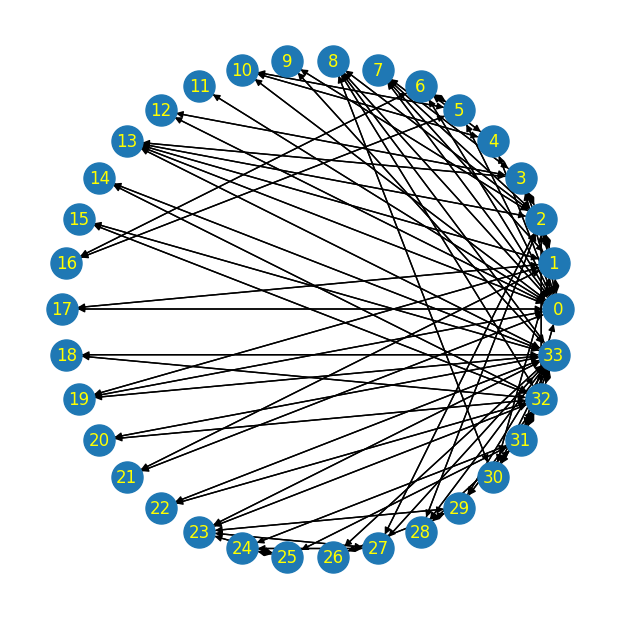

In [ ]:
nx_graph = convert_jraph_to_networkx_graph(graph)
pos = nx.circular_layout(nx_graph)
plt.figure(figsize=(6, 6))
nx.draw(nx_graph, pos=pos, with_labels = True, node_size=500, font_color='yellow')

Define the GCN with the `GraphConvolution` layers we implemented:

In [ ]:
def gcn_definition(graph: jraph.GraphsTuple) -> jraph.GraphsTuple:
  """Defines a GCN for the karate club task.
  Args:
    graph: GraphsTuple the network processes.

  Returns:
    output graph with updated node values.
  """
  gn = GraphConvolution(
      update_node_fn=lambda n: jax.nn.relu(hk.Linear(8)(n)),
      add_self_edges=True)
  graph = gn(graph)

  gn = GraphConvolution(
      update_node_fn=hk.Linear(2)) # output dim is 2 because we have 2 output classes.
  graph = gn(graph)
  return graph

Training and evaluation code:

In [ ]:
def optimize_club(network: hk.Transformed, num_steps: int) -> jnp.ndarray:
  """Solves the karate club problem by optimizing the assignments of students."""
  zacharys_karate_club = get_zacharys_karate_club()
  labels = get_ground_truth_assignments_for_zacharys_karate_club()
  params = network.init(jax.random.PRNGKey(42), zacharys_karate_club)

  @jax.jit
  def predict(params: hk.Params) -> jnp.ndarray:
    decoded_graph = network.apply(params, zacharys_karate_club)
    return jnp.argmax(decoded_graph.nodes, axis=1)

  @jax.jit
  def prediction_loss(params: hk.Params) -> jnp.ndarray:
    decoded_graph = network.apply(params, zacharys_karate_club)
    # We interpret the decoded nodes as a pair of logits for each node.
    log_prob = jax.nn.log_softmax(decoded_graph.nodes)
    # The only two assignments we know a-priori are those of Mr. Hi (Node 0)
    # and John A (Node 33).
    return -(log_prob[0, 0] + log_prob[33, 1])

  opt_init, opt_update = optax.adam(1e-2)
  opt_state = opt_init(params)

  @jax.jit
  def update(params: hk.Params, opt_state) -> Tuple[hk.Params, Any]:
    """Returns updated params and state."""
    g = jax.grad(prediction_loss)(params)
    updates, opt_state = opt_update(g, opt_state)
    return optax.apply_updates(params, updates), opt_state

  @jax.jit
  def accuracy(params: hk.Params) -> jnp.ndarray:
    decoded_graph = network.apply(params, zacharys_karate_club)
    return jnp.mean(jnp.argmax(decoded_graph.nodes, axis=1) == labels)

  for step in range(num_steps):
    print(f"step {step} accuracy {accuracy(params).item():.2f}")
    params, opt_state = update(params, opt_state)

  return predict(params)

Let's train the GCN! We expect this model reach an accuracy of about 0.91.

In [ ]:
network = hk.without_apply_rng(hk.transform(gcn_definition))
result_gcn = optimize_club(network, num_steps=25)

step 0 accuracy 0.06
step 1 accuracy 0.15
step 2 accuracy 0.35
step 3 accuracy 0.50
step 4 accuracy 0.59
step 5 accuracy 0.68
step 6 accuracy 0.71
step 7 accuracy 0.74
step 8 accuracy 0.74
step 9 accuracy 0.76
step 10 accuracy 0.76
step 11 accuracy 0.91
step 12 accuracy 0.91
step 13 accuracy 0.91
step 14 accuracy 0.91
step 15 accuracy 0.91
step 16 accuracy 0.94
step 17 accuracy 0.91
step 18 accuracy 0.91
step 19 accuracy 0.91
step 20 accuracy 0.94
step 21 accuracy 0.94
step 22 accuracy 0.94
step 23 accuracy 0.94
step 24 accuracy 0.97



Try modifying the model parameters to see if you can improve the accuracy!

You can also modify the dataset itself, and see how that influences model training.

Node assignments predicted by the model at the end of training:

In [ ]:
result_gcn

Array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

Visualize ground truth and predicted node assignments:

What do you think of the results?

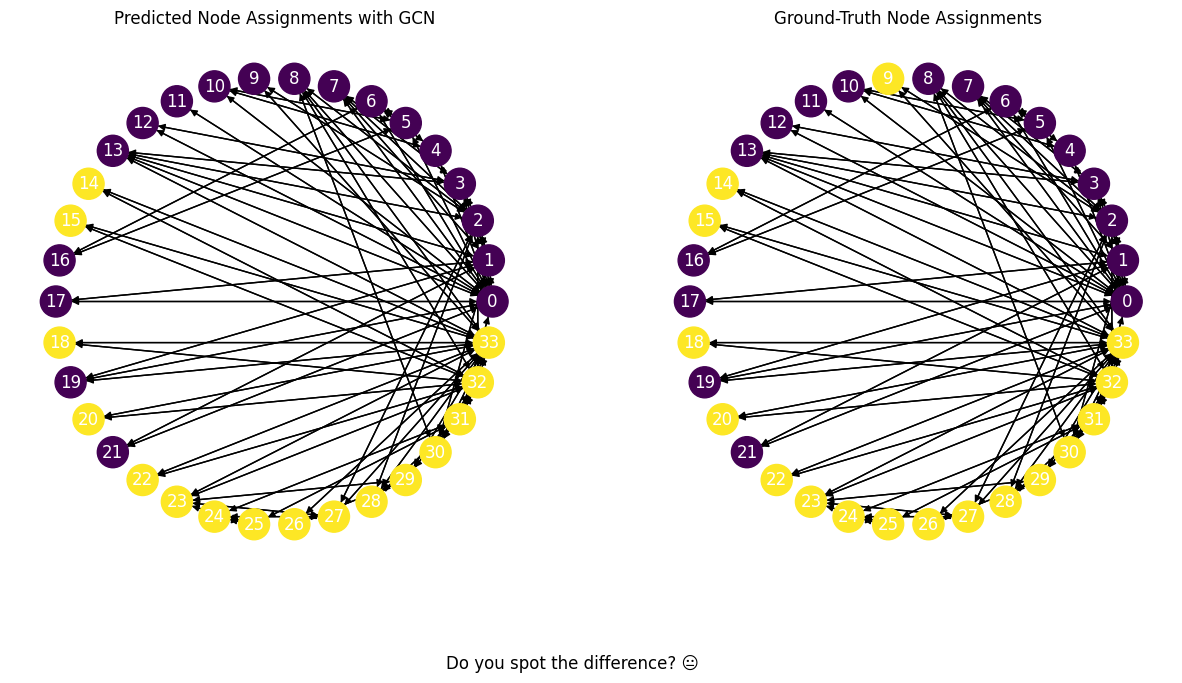

In [ ]:
zacharys_karate_club = get_zacharys_karate_club()
nx_graph = convert_jraph_to_networkx_graph(zacharys_karate_club)
pos = nx.circular_layout(nx_graph)

fig = plt.figure(figsize=(15, 7))
ax1 = fig.add_subplot(121)
nx.draw(
    nx_graph,
    pos=pos,
    with_labels=True,
    node_size=500,
    node_color=result_gcn.tolist(),
    font_color='white')
ax1.title.set_text('Predicted Node Assignments with GCN')

gt_labels = get_ground_truth_assignments_for_zacharys_karate_club()
ax2 = fig.add_subplot(122)
nx.draw(
    nx_graph,
    pos=pos,
    with_labels=True,
    node_size=500,
    node_color=gt_labels.tolist(),
    font_color='white')
ax2.title.set_text('Ground-Truth Node Assignments')
fig.suptitle('Do you spot the difference? 😐', y=-0.01)

plt.show()

#### $\color{#AA3939}{\text{Questions}}$

$\color{#AA3939}{\text{Q1.1:}}$ Implement the iterative label propagation (ILP) algorithm from the SSL classes using GCN (hint: it can be expressed as chain of GCN layers, but remember to symmetrize the graph first), and motivate/describe your choices in the implementation.

In [ ]:
club = get_zacharys_karate_club()
nodes = jnp.zeros((34,2))
nodes = nodes.at[7,0].set(1)
nodes = nodes.at[24,1].set(1)
club = club._replace(nodes=nodes)
# Define the iterative label propagation (ILP) algorithm
def ILP_algorithm(n=3):
  # ILP function with GCN
  def ILP_function(graph: jraph.GraphsTuple, n=n) -> jraph.GraphsTuple:
    for i in range(n):
      graph_convolution = GraphConvolution(update_node_fn=lambda nodes: nodes, add_self_edges=True)
      graph = graph_convolution(graph)
    return graph  
  net = hk.without_apply_rng(hk.transform(ILP_function)) # Transform to pure function
  parameters = net.init(jax.random.PRNGKey(42), club) # Initialize
  new_graph = net.apply(parameters, club) # Decoding 
  return jnp.argmax(new_graph.nodes, axis=1)


$\color{#AA3939}{\text{Q1.2:}}$ Compare accuracy of ILP and a GCN with MLP feature extraction on the Karate club dataset. (remember that \{0,1\} labels do not have a meaning for ILP)

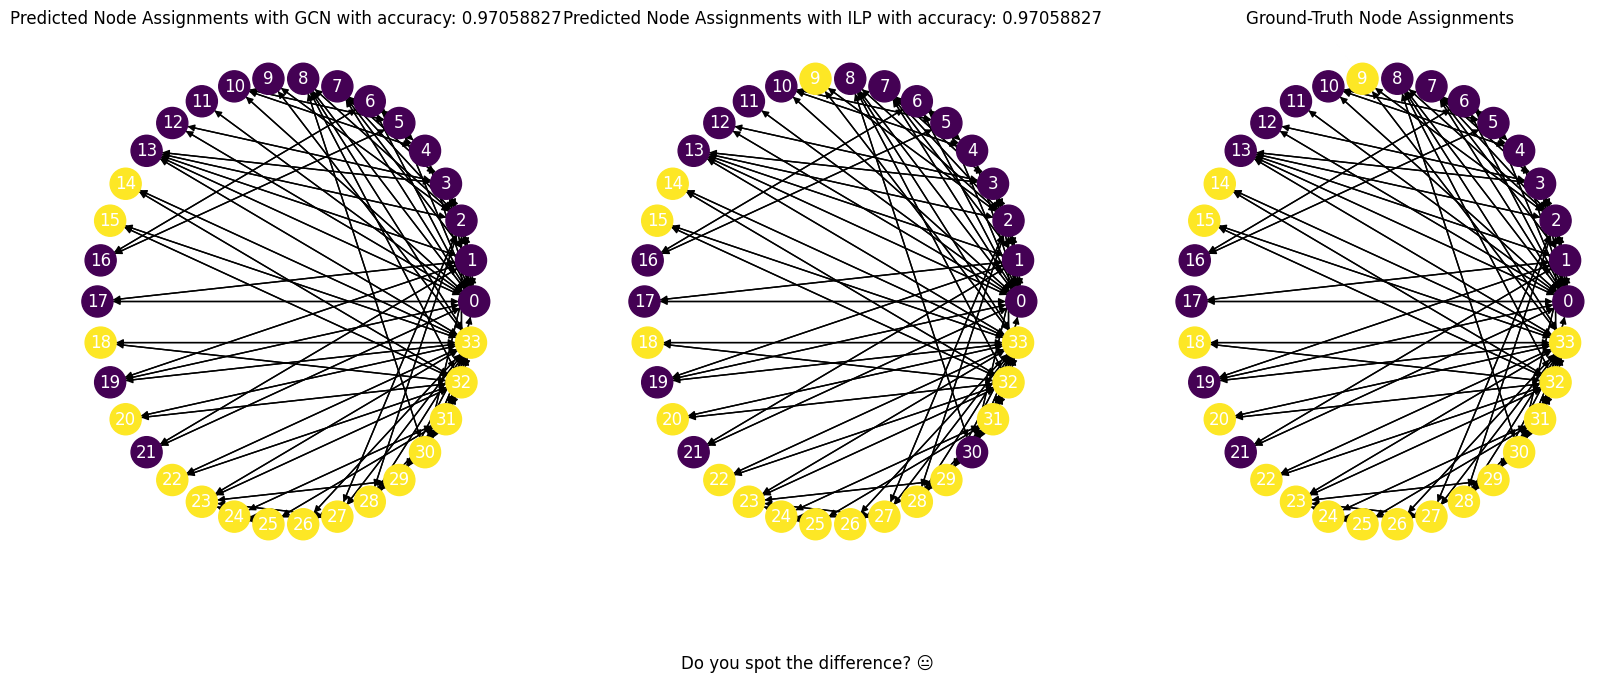

In [ ]:
@jax.jit
def accuracy(result: jnp.ndarray) -> jnp.ndarray: #add function to get the accuracy
  return jnp.mean(result == gt_labels)
result_ilp = ILP_algorithm(n=10)
zacharys_karate_club = get_zacharys_karate_club()
nx_graph = convert_jraph_to_networkx_graph(zacharys_karate_club)
pos = nx.circular_layout(nx_graph)

fig = plt.figure(figsize=(20, 7))
ax1 = fig.add_subplot(131)
nx.draw(
    nx_graph,
    pos=pos,
    with_labels=True,
    node_size=500,
    node_color=result_gcn.tolist(),
    font_color='white')
ax1.title.set_text('Predicted Node Assignments with GCN with accuracy: {}'.format(str(accuracy(result_gcn))))

gt_labels = get_ground_truth_assignments_for_zacharys_karate_club()
ax2 = fig.add_subplot(132)
nx.draw(
    nx_graph,
    pos=pos,
    with_labels=True,
    node_size=500,
    node_color=result_ilp.tolist(),
    font_color='white')
ax2.title.set_text('Predicted Node Assignments with ILP with accuracy: {}'.format(str(accuracy(result_ilp))))


gt_labels = get_ground_truth_assignments_for_zacharys_karate_club()
ax3 = fig.add_subplot(133)
nx.draw(
    nx_graph,
    pos=pos,
    with_labels=True,
    node_size=500,
    node_color=gt_labels.tolist(),
    font_color='white')
ax3.title.set_text('Ground-Truth Node Assignments')

fig.suptitle('Do you spot the difference? 😐', y=-0.01)

plt.show()

In our trial, we assessed the accuracy of each classifier and discovered that the number of repetitions has an effect on ILP performance. After two iterations, ILP performed marginally worse than GCN. However, after ten rounds, both models performed equally well, with an accuracy of 97%. Nonetheless, as the number of iterations grew, we noticed that labels propagated throughout the network, resulting in the majority of nodes having the same label. As a consequence, we determined that, while ILP and GCN can accomplish comparable results with a suitable amount of iterations, GCN is usually more efficient.

# Graph Attention (GAT) Layer

While the GCN we covered in the previous section can learn meaningful representations, it also has some shortcomings. Can you think of any?

In the GCN layer, the messages from all its neighbours and the node itself are equally weighted. This may lead to loss of node-specific information. E.g., consider the case when a set of nodes shares the same set of neighbors, and start out with different node features. Then because of averaging, their resulting output features would be the same. Adding self-edges mitigates this issue by a small amount, but this problem is magnified with increasing number of GCN layers and number of edges connecting to a node.

The graph attention (GAT) mechanism, as proposed by [Velickovic et al. ( 2017)](https://arxiv.org/abs/1710.10903), allows the network to learn how to weigh / assign importance to the node features from the neighbourhood when computing the new node features. This is very similar to the idea of using attention in Transformers, which were introduced in [Vaswani et al. (2017)](https://arxiv.org/abs/1706.03762).

(One could even argue that Transformers are graph attention networks operating on the special case of fully-connected graphs.)

In the figure below, $\vec{h}$ are the node features and $\vec{\alpha}$ are the learned attention weights.



<image src="https://storage.googleapis.com/dm-educational/assets/graph-nets/gat1.png" width="400px">

Figure Credit: [Velickovic et al. ( 2017)](https://arxiv.org/abs/1710.10903).
(Detail: This image is showing multi-headed attention with 3 heads, each color corresponding to a different head. At the end, an aggregation function is applied over all the heads.)

To obtain the output node features of the GAT layer, we compute:

$$ \vec{h}'_i = \sum _{j \in \mathcal{N}(i)}\alpha_{ij} \mathbf{W} \vec{h}_j$$
Here, $\mathbf{W}$ is a weight matrix which performs a linear transformation on the input.





How do we obtain $\alpha$, or in other words, learn what to pay attention to?

Intuitively, the attention coefficient $\alpha_{ij}$ should rely on both the transformed features from nodes $i$ and $j$. So let's first define an attention mechanism function $\mathrm{attention\_fn}$ that computes the intermediary attention coefficients $e_{ij}$:
$$ e_{ij} = \mathrm{attention\_fn}(\mathbf{W}\vec{h}_i, \mathbf{W}\vec{h}_j)$$

To obtain normalized attention weights $\alpha$, we apply a softmax:
$$\alpha_{ij} = \frac{\exp(e_{ij})}{\sum _{j \in \mathcal{N}(i)}\exp(e_{ij})}$$

For the function $a$, the authors of the GAT paper chose to concatenate the transformed node features (denoted by $||$) and apply a single-layer feedforward network, parameterized by a weight vector $\vec{\mathbf{a}}$ and with LeakyRelu as non-linearity.

In the implementation below, we refer to $\mathbf{W}$ as `attention_query_fn` and $att\_fn$ as `attention_logit_fn`.

$$\mathrm{attention\_fn}(\mathbf{W}\vec{h}_i, \mathbf{W}\vec{h}_j) =  \text{LeakyReLU}(\vec{\mathbf{a}}(\mathbf{W}\vec{h}_i || \mathbf{W}\vec{h}_j))$$

The figure below summarizes this attention mechanism visually.

<image src="https://storage.googleapis.com/dm-educational/assets/graph-nets/gat2.png" width="300px">

Figure Credit: Petar Velickovic.
<!-- $\sum_{j \in \mathcal{N}(i)}\vec{\alpha}_{ij} \stackrel{!}{=}
1 $  -->



In [ ]:
# GAT implementation adapted from https://github.com/deepmind/jraph/blob/master/jraph/_src/models.py#L442.
def GAT(attention_query_fn: Callable,
        attention_logit_fn: Callable,
        node_update_fn: Optional[Callable] = None,
        add_self_edges: bool = True) -> Callable:
  """Returns a method that applies a Graph Attention Network layer.

  Graph Attention message passing as described in
  https://arxiv.org/pdf/1710.10903.pdf. This model expects node features as a
  jnp.array, may use edge features for computing attention weights, and
  ignore global features. It does not support nests.
  Args:
    attention_query_fn: function that generates attention queries from sender
      node features.
    attention_logit_fn: function that converts attention queries into logits for
      softmax attention.
    node_update_fn: function that updates the aggregated messages. If None, will
      apply leaky relu and concatenate (if using multi-head attention).

  Returns:
    A function that applies a Graph Attention layer.
  """
  # pylint: disable=g-long-lambda
  if node_update_fn is None:
    # By default, apply the leaky relu and then concatenate the heads on the
    # feature axis.
    node_update_fn = lambda x: jnp.reshape(
        jax.nn.leaky_relu(x), (x.shape[0], -1))

  def _ApplyGAT(graph: jraph.GraphsTuple) -> jraph.GraphsTuple:
    """Applies a Graph Attention layer."""
    nodes, edges, receivers, senders, _, _, _ = graph
    # Equivalent to the sum of n_node, but statically known.
    try:
      sum_n_node = nodes.shape[0]
    except IndexError:
      raise IndexError('GAT requires node features')

    # Pass nodes through the attention query function to transform
    # node features, e.g. with an MLP.
    nodes = attention_query_fn(nodes)

    total_num_nodes = tree.tree_leaves(nodes)[0].shape[0]
    if add_self_edges:
      # We add self edges to the senders and receivers so that each node
      # includes itself in aggregation.
      receivers, senders = add_self_edges_fn(receivers, senders,
                                             total_num_nodes)

    # We compute the softmax logits using a function that takes the
    # embedded sender and receiver attributes.
    sent_attributes = nodes[senders]
    received_attributes = nodes[receivers]
    att_softmax_logits = attention_logit_fn(sent_attributes,
                                            received_attributes, edges)

    # Compute the attention softmax weights on the entire tree.
    att_weights = jraph.segment_softmax(
        att_softmax_logits, segment_ids=receivers, num_segments=sum_n_node)

    # Apply attention weights.
    messages = sent_attributes * att_weights
    # Aggregate messages to nodes.
    nodes = jax.ops.segment_sum(messages, receivers, num_segments=sum_n_node)

    # Apply an update function to the aggregated messages.
    nodes = node_update_fn(nodes)

    return graph._replace(nodes=nodes)

  # pylint: enable=g-long-lambda
  return _ApplyGAT

#### Test GAT Layer

In [ ]:
def attention_logit_fn(sender_attr: jnp.ndarray, receiver_attr: jnp.ndarray,
                       edges: jnp.ndarray) -> jnp.ndarray:
  del edges
  x = jnp.concatenate((sender_attr, receiver_attr), axis=1)
  return hk.Linear(1)(x)


gat_layer = GAT(
    attention_query_fn=lambda n: hk.Linear(8)
    (n),  # Applies W to the node features
    attention_logit_fn=attention_logit_fn,
    node_update_fn=None,
    add_self_edges=True,
)

In [ ]:
graph = build_toy_graph()
network = hk.without_apply_rng(hk.transform(gat_layer))
params = network.init(jax.random.PRNGKey(42), graph)
out_graph = network.apply(params, graph)
out_graph.nodes

Array([[-2.1254564e-02,  2.4042888e+00, -4.0143328e-03, -2.0577876e-02,
         1.8933861e+00,  1.1548430e+00, -5.3817671e-02, -1.0350263e-02],
       [-6.7768171e-03,  7.6658487e-01, -1.2799322e-03, -6.5610623e-03,
         6.0368836e-01,  3.6821082e-01, -1.7159259e-02, -3.3000838e-03],
       [-2.1208901e-02,  2.3991237e+00, -4.0057092e-03, -2.0533672e-02,
         1.8893186e+00,  1.1523621e+00, -5.3702056e-02, -1.0328028e-02],
       [-1.7733721e-02,  2.0060158e+00, -3.3493543e-03, -1.7169129e-02,
         1.5797446e+00,  9.6354198e-01, -4.4902720e-02, -8.6357296e-03]],      dtype=float32)

#### Train GAT Model on Karate Club Dataset
We will now repeat the karate club experiment with a GAT network.

In [ ]:
def gat_definition(graph: jraph.GraphsTuple) -> jraph.GraphsTuple:
  """Defines a GAT network for the karate club node classification task.

  Args:
    graph: GraphsTuple the network processes.

  Returns:
    output graph with updated node values.
  """

  def _attention_logit_fn(sender_attr: jnp.ndarray, receiver_attr: jnp.ndarray,
                          edges: jnp.ndarray) -> jnp.ndarray:
    del edges
    x = jnp.concatenate((sender_attr, receiver_attr), axis=1)
    return hk.Linear(1)(x)

  gn = GAT(
      attention_query_fn=lambda n: hk.Linear(8)(n),
      attention_logit_fn=_attention_logit_fn,
      node_update_fn=None,
      add_self_edges=True)
  graph = gn(graph)

  gn = GAT(
      attention_query_fn=lambda n: hk.Linear(8)(n),
      attention_logit_fn=_attention_logit_fn,
      node_update_fn=hk.Linear(2),
      add_self_edges=True)
  graph = gn(graph)
  return graph

Let's train the model!

We expect the model to reach an accuracy of about 0.97.

In [ ]:
network = hk.without_apply_rng(hk.transform(gat_definition))
result = optimize_club(network, num_steps=15)

step 0 accuracy 0.50
step 1 accuracy 0.94
step 2 accuracy 0.94
step 3 accuracy 0.94
step 4 accuracy 0.97
step 5 accuracy 0.97
step 6 accuracy 0.97
step 7 accuracy 0.97
step 8 accuracy 0.97
step 9 accuracy 0.97
step 10 accuracy 1.00
step 11 accuracy 1.00
step 12 accuracy 1.00
step 13 accuracy 0.97
step 14 accuracy 0.97


The final node assignment predicted by the trained model:

In [ ]:
result

Array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

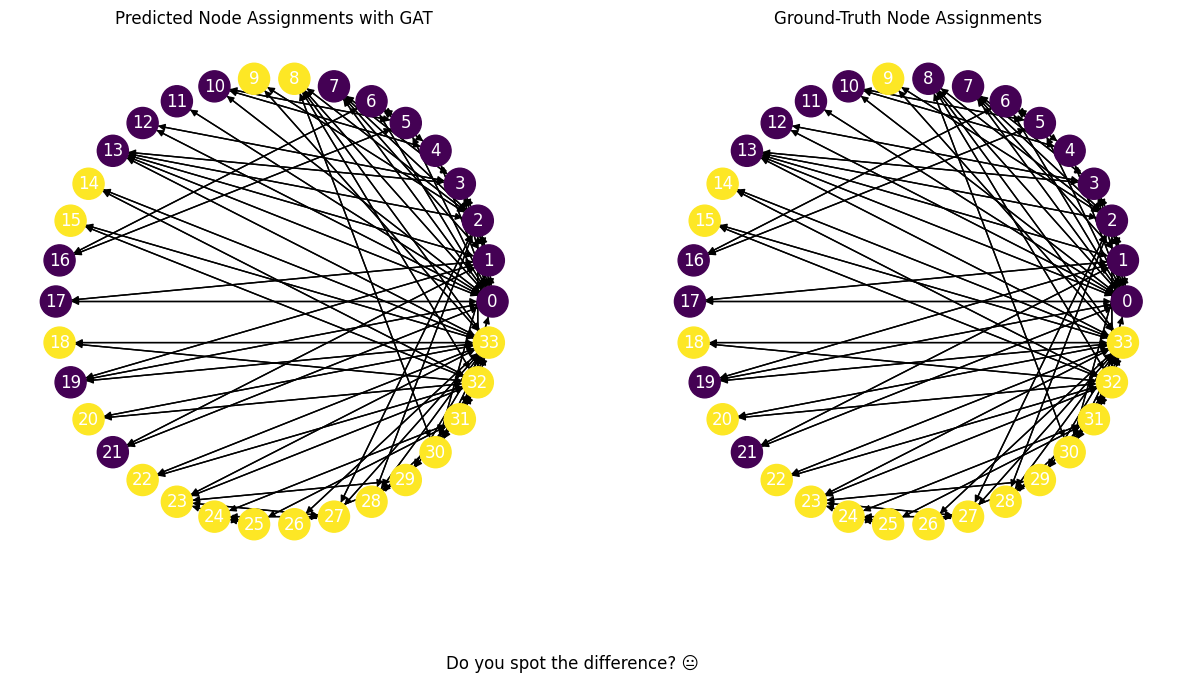

In [ ]:
zacharys_karate_club = get_zacharys_karate_club()
nx_graph = convert_jraph_to_networkx_graph(zacharys_karate_club)
pos = nx.circular_layout(nx_graph)

fig = plt.figure(figsize=(15, 7))
ax1 = fig.add_subplot(121)
nx.draw(
    nx_graph,
    pos=pos,
    with_labels=True,
    node_size=500,
    node_color=result.tolist(),
    font_color='white')
ax1.title.set_text('Predicted Node Assignments with GAT')

gt_labels = get_ground_truth_assignments_for_zacharys_karate_club()
ax2 = fig.add_subplot(122)
nx.draw(
    nx_graph,
    pos=pos,
    with_labels=True,
    node_size=500,
    node_color=gt_labels.tolist(),
    font_color='white')
ax2.title.set_text('Ground-Truth Node Assignments')
fig.suptitle('Do you spot the difference? 😐', y=-0.01)
plt.show()

# Graph Classification on MUTAG (Molecules)

In the previous section, we used our GCN and GAT networks on a node classification problem. Now, let's use the same model architectures on a **graph classification task**.

The main difference from our previous setup is that instead of observing individual node latents, we are now attempting to summarize them into one embedding vector, representative of the entire graph, which we then use to predict the class of this graph.

We will do this on one of the most common tasks of this type -- **molecular property prediction**, where molecules are represented as graphs. Nodes correspond to atoms, and edges represent the bonds between them.

We will use the **MUTAG** dataset for this example, a common dataset from the [TUDatasets](https://chrsmrrs.github.io/datasets/) collection.

We have converted this dataset to be compatible with jraph and will download it in the cell below.

Citation for TUDatasets: [Morris, Christopher, et al. Tudataset: A collection of benchmark datasets for learning with graphs. arXiv preprint arXiv:2007.08663. 2020.](https://chrsmrrs.github.io/datasets/)


In [ ]:
# Download jraph version of MUTAG.
!wget -P /tmp/ https://storage.googleapis.com/dm-educational/assets/graph-nets/jraph_datasets/mutag.pickle
with open('/tmp/mutag.pickle', 'rb') as f:
  mutag_ds = pickle.load(f)

--2023-04-02 15:13:03--  https://storage.googleapis.com/dm-educational/assets/graph-nets/jraph_datasets/mutag.pickle
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.63.128, 142.250.31.128, 142.251.111.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.63.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 352981 (345K) [application/octet-stream]
Saving to: ‘/tmp/mutag.pickle.4’

mutag.pickle.4      100%[===================>] 344.71K  --.-KB/s    in 0.004s  

2023-04-02 15:13:03 (85.4 MB/s) - ‘/tmp/mutag.pickle.4’ saved [352981/352981]



The dataset is saved as a list of examples, each example is a dictionary containing an input_graph and its corresponding target.

In [ ]:
len(mutag_ds)

188

In [ ]:
# Inspect the first graph
g = mutag_ds[0]['input_graph']
print(f'Number of nodes: {g.n_node[0]}')
print(f'Number of edges: {g.n_edge[0]}')
print(f'Node features shape: {g.nodes.shape}')
print(f'Edge features shape: {g.edges.shape}')

Number of nodes: 17
Number of edges: 38
Node features shape: (17, 7)
Edge features shape: (38, 4)


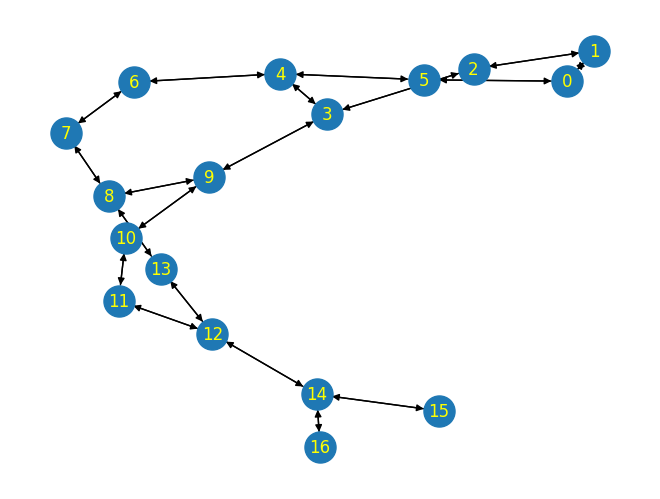

In [ ]:
draw_jraph_graph_structure(g)

In [ ]:
# Target for first graph
print(f"Target: {mutag_ds[0]['target']}")

Target: [1]


We see that there are 188 graphs, to be classified in one of 2 classes, representing "their mutagenic effect on a specific gram negative bacterium". Node features represent the 1-hot encoding of the atom type (0=C, 1=N, 2=O, 3=F, 4=I, 5=Cl, 6=Br). Edge features (`edge_attr`) represent the bond type, which we will here ignore.

Let's split the dataset to use the first 150 graphs as the training set (and the rest as the test set).

In [ ]:
train_mutag_ds = mutag_ds[:150]
test_mutag_ds = mutag_ds[150:]

#### Padding Graphs to Speed Up Training

Since jax recompiles the program for each graph size, training would take a long time due to recompilation for different graph sizes. To address that, we pad the number of nodes and edges in the graphs to nearest power of two. Since jax maintains a cache
of compiled programs, the compilation cost is amortized.

In [ ]:
# Adapted from https://github.com/deepmind/jraph/blob/master/jraph/ogb_examples/train.py
def _nearest_bigger_power_of_two(x: int) -> int:
  """Computes the nearest power of two greater than x for padding."""
  y = 2
  while y < x:
    y *= 2
  return y

def pad_graph_to_nearest_power_of_two(
    graphs_tuple: jraph.GraphsTuple) -> jraph.GraphsTuple:
  """Pads a batched `GraphsTuple` to the nearest power of two.
  For example, if a `GraphsTuple` has 7 nodes, 5 edges and 3 graphs, this method
  would pad the `GraphsTuple` nodes and edges:
    7 nodes --> 8 nodes (2^3)
    5 edges --> 8 edges (2^3)
  And since padding is accomplished using `jraph.pad_with_graphs`, an extra
  graph and node is added:
    8 nodes --> 9 nodes
    3 graphs --> 4 graphs
  Args:
    graphs_tuple: a batched `GraphsTuple` (can be batch size 1).
  Returns:
    A graphs_tuple batched to the nearest power of two.
  """
  # Add 1 since we need at least one padding node for pad_with_graphs.
  pad_nodes_to = _nearest_bigger_power_of_two(jnp.sum(graphs_tuple.n_node)) + 1
  pad_edges_to = _nearest_bigger_power_of_two(jnp.sum(graphs_tuple.n_edge))
  # Add 1 since we need at least one padding graph for pad_with_graphs.
  # We do not pad to nearest power of two because the batch size is fixed.
  pad_graphs_to = graphs_tuple.n_node.shape[0] + 1
  return jraph.pad_with_graphs(graphs_tuple, pad_nodes_to, pad_edges_to,
                               pad_graphs_to)

#### Graph Network Model Definition

We will use `jraph.GraphNetwork()` to build our graph model. The `GraphNetwork` architecture is defined in [Battaglia et al. (2018)](https://arxiv.org/pdf/1806.01261.pdf).

We first define update functions for nodes, edges, and the full graph (global). We will use MLP blocks for all three.

In [ ]:
# Adapted from https://github.com/deepmind/jraph/blob/master/jraph/ogb_examples/train.py
@jraph.concatenated_args
def edge_update_fn(feats: jnp.ndarray) -> jnp.ndarray:
  """Edge update function for graph net."""
  net = hk.Sequential(
      [hk.Linear(128), jax.nn.relu,
       hk.Linear(128)])
  return net(feats)

@jraph.concatenated_args
def node_update_fn(feats: jnp.ndarray) -> jnp.ndarray:
  """Node update function for graph net."""
  net = hk.Sequential(
      [hk.Linear(128), jax.nn.relu,
       hk.Linear(128)])
  return net(feats)

@jraph.concatenated_args
def update_global_fn(feats: jnp.ndarray) -> jnp.ndarray:
  """Global update function for graph net."""
  # MUTAG is a binary classification task, so output pos neg logits.
  net = hk.Sequential(
      [hk.Linear(128), jax.nn.relu,
       hk.Linear(2)])
  return net(feats)

def net_fn(graph: jraph.GraphsTuple) -> jraph.GraphsTuple:
  # Add a global paramater for graph classification.
  graph = graph._replace(globals=jnp.zeros([graph.n_node.shape[0], 1]))
  embedder = jraph.GraphMapFeatures(
      hk.Linear(128), hk.Linear(128), hk.Linear(128))
  net = jraph.GraphNetwork(
      update_node_fn=node_update_fn,
      update_edge_fn=edge_update_fn,
      update_global_fn=update_global_fn)
  return net(embedder(graph))

#### Loss and Accuracy Function
Define the classification cross-entropy loss and accuracy function.

In [ ]:
def compute_loss(params: hk.Params, graph: jraph.GraphsTuple, label: jnp.ndarray,
                 net: jraph.GraphsTuple) -> Tuple[jnp.ndarray, jnp.ndarray]:
  """Computes loss and accuracy."""
  pred_graph = net.apply(params, graph)
  preds = jax.nn.log_softmax(pred_graph.globals)
  targets = jax.nn.one_hot(label, 2)

  # Since we have an extra 'dummy' graph in our batch due to padding, we want
  # to mask out any loss associated with the dummy graph.
  # Since we padded with `pad_with_graphs` we can recover the mask by using
  # get_graph_padding_mask.
  mask = jraph.get_graph_padding_mask(pred_graph)

  # Cross entropy loss.
  loss = -jnp.mean(preds * targets * mask[:, None])

  # Accuracy taking into account the mask.
  accuracy = jnp.sum(
      (jnp.argmax(pred_graph.globals, axis=1) == label) * mask) / jnp.sum(mask)
  return loss, accuracy

#### Training and Evaluation Functions

In [ ]:
# Adapted from https://github.com/deepmind/jraph/blob/master/jraph/ogb_examples/train.py
def train(dataset: List[Dict[str, Any]], num_train_steps: int) -> hk.Params:
  """Training loop."""

  # Transform impure `net_fn` to pure functions with hk.transform.
  net = hk.without_apply_rng(hk.transform(net_fn))
  # Get a candidate graph and label to initialize the network.
  graph = dataset[0]['input_graph']

  # Initialize the network.
  params = net.init(jax.random.PRNGKey(42), graph)
  # Initialize the optimizer.
  opt_init, opt_update = optax.adam(1e-4)
  opt_state = opt_init(params)

  compute_loss_fn = functools.partial(compute_loss, net=net)
  # We jit the computation of our loss, since this is the main computation.
  # Using jax.jit means that we will use a single accelerator. If you want
  # to use more than 1 accelerator, use jax.pmap. More information can be
  # found in the jax documentation.
  compute_loss_fn = jax.jit(jax.value_and_grad(
      compute_loss_fn, has_aux=True))

  for idx in range(num_train_steps):
    graph = dataset[idx % len(dataset)]['input_graph']
    label = dataset[idx % len(dataset)]['target']
    # Jax will re-jit your graphnet every time a new graph shape is encountered.
    # In the limit, this means a new compilation every training step, which
    # will result in *extremely* slow training. To prevent this, pad each
    # batch of graphs to the nearest power of two. Since jax maintains a cache
    # of compiled programs, the compilation cost is amortized.
    graph = pad_graph_to_nearest_power_of_two(graph)

    # Since padding is implemented with pad_with_graphs, an extra graph has
    # been added to the batch, which means there should be an extra label.
    label = jnp.concatenate([label, jnp.array([0])])

    (loss, acc), grad = compute_loss_fn(params, graph, label)
    updates, opt_state = opt_update(grad, opt_state, params)
    params = optax.apply_updates(params, updates)
    if idx % 50 == 0:
      print(f'step: {idx}, loss: {loss}, acc: {acc}')
  print('Training finished')
  return params

In [ ]:
def evaluate(dataset: List[Dict[str, Any]],
             params: hk.Params) -> Tuple[jnp.ndarray, jnp.ndarray]:
  """Evaluation Script."""
  # Transform impure `net_fn` to pure functions with hk.transform.
  net = hk.without_apply_rng(hk.transform(net_fn))
  # Get a candidate graph and label to initialize the network.
  graph = dataset[0]['input_graph']
  accumulated_loss = 0
  accumulated_accuracy = 0
  compute_loss_fn = jax.jit(functools.partial(compute_loss, net=net))
  for idx in range(len(dataset)):
    graph = dataset[idx]['input_graph']
    label = dataset[idx]['target']
    graph = pad_graph_to_nearest_power_of_two(graph)
    label = jnp.concatenate([label, jnp.array([0])])
    loss, acc = compute_loss_fn(params, graph, label)
    accumulated_accuracy += acc
    accumulated_loss += loss
    if idx % 100 == 0:
      print(f'Evaluated {idx + 1} graphs')
  print('Completed evaluation.')
  loss = accumulated_loss / idx
  accuracy = accumulated_accuracy / idx
  print(f'Eval loss: {loss}, accuracy {accuracy}')
  return loss, accuracy

In [ ]:
params = train(train_mutag_ds, num_train_steps=500)

step: 0, loss: 0.28438901901245117, acc: 0.0
step: 50, loss: 0.0006321418331936002, acc: 1.0
step: 100, loss: 0.0013380241580307484, acc: 1.0
step: 150, loss: 0.04702802002429962, acc: 1.0
step: 200, loss: 0.041739754378795624, acc: 1.0
step: 250, loss: 0.0028245325665920973, acc: 1.0
step: 300, loss: 0.047925956547260284, acc: 1.0
step: 350, loss: 0.032259102910757065, acc: 1.0
step: 400, loss: 0.003068581223487854, acc: 1.0
step: 450, loss: 0.036227911710739136, acc: 1.0
Training finished


In [ ]:
evaluate(test_mutag_ds, params)

Evaluated 1 graphs
Completed evaluation.
Eval loss: 0.14461466670036316, accuracy 0.7567567229270935


(Array(0.14461467, dtype=float32), Array(0.7567567, dtype=float32))

We converge at ~76% test accuracy. We could of course further tune the parameters to improve this result.

### $\color{#AA3939}{\text{Questions}}$

$\color{#AA3939}{\text{Q2.1:}}$ One of the main use cases of GNNs is feature extraction. Use the network you trained in the previous section to exctract embeddings (i.e. vectorial representations) of each MUTAG graph.

In [ ]:
# Restate the function to get output result 
@jraph.concatenated_args
def update_global_fn_(feats: jnp.ndarray) -> jnp.ndarray:
  """Global update function for graph net."""
  # We need to obtain output pos neg logits
  net = hk.Sequential(
      [hk.Linear(128)])
  return net(feats)

def Net():
  def Net_function():

    # Define blocks
    embedder_block = jraph.GraphMapFeatures(hk.Linear(128), hk.Linear(128), hk.Linear(128))
    net_block = jraph.GraphNetwork(
        update_node_fn=node_update_fn,
        update_edge_fn=edge_update_fn,
        update_global_fn=update_global_fn_)
    # Define functions for network
    # Initiliazation
    def init(graph):
      full(graph._replace(globals=jnp.zeros([graph.n_node.shape[0], 1])))
    # Full Network
    def full(graph):
      return net_block(embedder_block(graph._replace(globals=jnp.zeros([graph.n_node.shape[0], 1]))))
    # Embeging
    def embedding(graph):
      return embedder_block(graph._replace(globals=jnp.zeros([graph.n_node.shape[0], 1])))  
    return init, (full, embedding)

  return Net_function

# transform and get full Net
Net = hk.multi_transform(Net())
full_Net, _ = Net.apply

embeddings = []
for i in range(len(mutag_ds)):
  graph = pad_graph_to_nearest_power_of_two(mutag_ds[i]['input_graph'])
  # # In computing graph-level features as embedding, we consider the first vector as the two columns of the returned vector are observed to be identical.
  embeddings.append(full_Net(params, None, graph).globals[0,:])

# Present first embedding
embeddings[0]

Array([ 1.1606444 , -2.2722502 , -1.7149005 ,  1.1091564 ,  4.145954  ,
       -0.55834705,  1.4670651 , -4.6098437 , -1.6139202 , -1.6593293 ,
       -4.625734  , -0.92838746, -0.6391756 ,  5.1587577 , -1.8365129 ,
       -0.04882487,  3.4403107 , -4.881426  ,  0.29264334, -4.6413565 ,
        2.8666537 ,  2.4461386 , -0.15808035,  1.4802463 , -4.390567  ,
       -2.8113818 , -1.2843663 ,  1.6958288 , -1.7855587 , -0.62076694,
        1.2371136 , -4.9880223 ,  1.2529029 , -0.86889726, -1.4796431 ,
        0.90209097, -1.5510428 ,  2.511042  , -0.19376597, -4.679249  ,
        0.2245961 ,  2.0114393 , -0.4771885 ,  1.2720137 , -1.633333  ,
       -1.0400364 , -0.9427228 ,  3.451848  , -0.4735694 ,  4.338222  ,
       -1.9679542 ,  3.4755554 ,  5.616689  , -1.7083714 , -2.5577474 ,
       -4.3069897 , -1.2805945 , -1.9047077 , -3.6853917 , -2.8090806 ,
       -2.5056896 , -0.8905844 , -3.8462846 ,  2.0215514 ,  0.72426814,
       -0.20677632, -1.6768999 , -2.6576624 , -3.974825  , -1.50

We use a network to generate embeddings for each MUTAG graph in this study, choosing to extract vector representations from the penultimate layer using the multi_transform. We investigate the globals attribute of the embedding graph by computing the graph-level features as embeddings and acquire a (2, 128) matrix, observing that both column vectors are similar. As a result, we choose the first column vector as our MUTAG graph embedding model.

$\color{#AA3939}{\text{Q2.2:}}$ Use the extracted embedding to cluster the graphs, and visualize the clustering. Does it agree with the class labels? Why (or why not)?

In [ ]:
from sklearn.cluster import KMeans
import pandas as pd
pd.set_option('display.max_columns', None)
X = onp.array([embedding for embedding in embeddings])
model = KMeans(n_clusters=2, random_state=0).fit(X)
# Clustering and true labels
labels = model.labels_
true=[]
for i in range(len(mutag_ds)):
  true.append(mutag_ds[i]['target'][0])
true_labels = onp.array(true)
df = pd.DataFrame([labels, true], index = ['Clustering', 'True'])
accuracy = jnp.mean( onp.array(labels) == true_labels)
print('Accuracy = {}'.format(accuracy))
df

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Accuracy = 0.7021276354789734


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187
Clustering,1,0,0,1,0,1,0,0,0,0,1,1,1,0,1,1,0,0,0,0,0,0,1,1,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,1,0,1,1,0,0,0,1,0,1,1,0,0,0,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,1,1,1,0,0,1,1,0,1,1,0,1,0,0,0,0,1,0,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,1,1,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,1,0,1,1,1,1,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,1,0
True,1,0,0,1,0,1,0,1,0,1,1,1,1,0,1,1,0,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,0,1,0,0,0,1,0,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,0,1,1,0,0,1,1,1,0,1,1,0,1,1,0,0,0,1,1,1,1,1,0,1,1,1,0,0,1,1,1,1,1,1,1,1,0,1,0,1,1,1,1,1,1,1,1,1,0,0,1,0,0,1,0,1,1,0,0,1,1,0,0,1,1,1,1,0,0,0,0,0,1,0,1,1,0,0,1,0,0,0,0,1,1,0,1,1,0,1,1,1,0,0,0,1,1,1,0,1,1,1,1,1,1,1,0,1,1,1,1,1,1,0,1,1,1,0,1,0,0,1,1,0,0,1,0


# Link prediction on CORA (Citation Network)

The final problem type we will explore is **link prediction**, an instance of an **edge-level** task. Given a graph, our goal is to predict whether a certain edge $(u,v)$ should be present or not. This is often useful in the recommender system settings (e.g., propose new friends in a social network, propose a movie to a user).

As before, the first step is to obtain node latents $h_i$ using a GNN. In this context we will use the autoencoder language and call this GNN **encoder**. Then, we learn a binary classifier $f: (h_i, h_j) \to z_{i,j}$ (**decoder**), predicting if an edge $(i,j)$ should exist or not. While we could use a more elaborate decoder (e.g., an MLP), a common approach we will also use here is to focus on obtaining good node embeddings, and for the decoder simply use the similarity between node latents, i.e. $z_{i,j} = h_i^T h_j$.


For this problem we will use the [**Cora** dataset](https://linqs.github.io/linqs-website/datasets/#cora), a citation graph containing 2708 scientific publications. For each publication we have a 1433-dimensional feature vector, which is a bag-of-words representation (with a small, fixed dictionary) of the paper text. The edges in this graph represent citations, and are commonly treated as undirected. Each paper is in one of seven topics (classes) so you can also use this dataset for node classification.

Similar to MUTAG, we have converted this dataset to jraph for you.

Citation for the use of the Cora dataset:
- [Qing Lu and Lise Getoor. Link-Based Classification. International Conference on Machine Learning. 2003.](https://linqs.github.io/linqs-website/publications/#id:lu-icml03)
- [Sen, Prithviraj, et al. Collective classification in network data. AI magazine 29.3. 2008.](https://linqs.github.io/linqs-website/datasets/#cora)
- [Dataset download link](https://linqs.github.io/linqs-website/datasets/#cora)




In [ ]:
# Download jraph version of Cora.
!wget -P /tmp/ https://storage.googleapis.com/dm-educational/assets/graph-nets/jraph_datasets/cora.pickle
with open('/tmp/cora.pickle', 'rb') as f:
  cora_ds = pickle.load(f)

--2023-04-02 15:14:13--  https://storage.googleapis.com/dm-educational/assets/graph-nets/jraph_datasets/cora.pickle
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.16.128, 172.253.62.128, 172.253.115.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.16.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15618018 (15M) [application/octet-stream]
Saving to: ‘/tmp/cora.pickle.4’

cora.pickle.4       100%[===================>]  14.89M  --.-KB/s    in 0.1s    

2023-04-02 15:14:13 (130 MB/s) - ‘/tmp/cora.pickle.4’ saved [15618018/15618018]



#### Splitting Edges and Adding "Negative" Edges
For the link prediction task, we split the edges into train, val and test sets and also add "negative" examples (edges that do not correspond to a citation). We will ignore the topic classes.

For the validation and test splits, we add the same number of existing edges ("positive examples") and non-existing edges ("negative examples").

In contrast to the validation and test splits, the training split only contains positive examples (set $T_+$). The $|T_+|$ negative examples to be used during training will be sampled ad hoc in each epoch and uniformly at random from all edges that are not in $T_+$. This allows the model to see a wider range of negative examples.

In [ ]:
def train_val_test_split_edges(graph: jraph.GraphsTuple,
                               val_perc: float = 0.05,
                               test_perc: float = 0.1):
  """Split edges in input graph into train, val and test splits.

  For val and test sets, also include negative edges.
  Based on torch_geometric.utils.train_test_split_edges.
  """
  mask = graph.senders < graph.receivers
  senders = graph.senders[mask]
  receivers = graph.receivers[mask]
  num_val = int(val_perc * senders.shape[0])
  num_test = int(test_perc * senders.shape[0])
  permuted_indices = onp.random.permutation(range(senders.shape[0]))
  senders = senders[permuted_indices]
  receivers = receivers[permuted_indices]
  if graph.edges is not None:
    edges = graph.edges[permuted_indices]

  val_senders = senders[:num_val]
  val_receivers = receivers[:num_val]
  if graph.edges is not None:
    val_edges = edges[:num_val]

  test_senders = senders[num_val:num_val + num_test]
  test_receivers = receivers[num_val:num_val + num_test]
  if graph.edges is not None:
    test_edges = edges[num_val:num_val + num_test]

  train_senders = senders[num_val + num_test:]
  train_receivers = receivers[num_val + num_test:]
  train_edges = None
  if graph.edges is not None:
    train_edges = edges[num_val + num_test:]

  # make training edges undirected by adding reverse edges back in
  train_senders_undir = jnp.concatenate((train_senders, train_receivers))
  train_receivers_undir = jnp.concatenate((train_receivers, train_senders))
  train_senders = train_senders_undir
  train_receivers = train_receivers_undir

  # Negative edges.
  num_nodes = graph.n_node[0]
  # Create a negative adjacency mask, s.t. mask[i, j] = True iff edge i->j does
  # not exist in the original graph.
  neg_adj_mask = onp.ones((num_nodes, num_nodes), dtype=onp.uint8)
  # upper triangular part
  neg_adj_mask = onp.triu(neg_adj_mask, k=1)
  neg_adj_mask[graph.senders, graph.receivers] = 0
  neg_adj_mask = neg_adj_mask.astype(onp.bool)
  neg_senders, neg_receivers = neg_adj_mask.nonzero()

  perm = onp.random.permutation(range(len(neg_senders)))
  neg_senders = neg_senders[perm]
  neg_receivers = neg_receivers[perm]

  val_neg_senders = neg_senders[:num_val]
  val_neg_receivers = neg_receivers[:num_val]
  test_neg_senders = neg_senders[num_val:num_val + num_test]
  test_neg_receivers = neg_receivers[num_val:num_val + num_test]

  train_graph = jraph.GraphsTuple(
      nodes=graph.nodes,
      edges=train_edges,
      senders=train_senders,
      receivers=train_receivers,
      n_node=graph.n_node,
      n_edge=jnp.array([len(train_senders)]),
      globals=graph.globals)

  return train_graph, neg_adj_mask, val_senders, val_receivers, val_neg_senders, val_neg_receivers, test_senders, test_receivers, test_neg_senders, test_neg_receivers

#### Test the Edge Splitting Function

In [ ]:
graph = cora_ds[0]['input_graph']
train_graph, neg_adj_mask, val_pos_senders, val_pos_receivers, val_neg_senders, val_neg_receivers, test_pos_senders, test_pos_receivers, test_neg_senders, test_neg_receivers = train_val_test_split_edges(graph)

<ipython-input-63-37bddf7861ba>:50: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  neg_adj_mask = neg_adj_mask.astype(onp.bool)


In [ ]:
print(f'Train set: {train_graph.senders.shape[0]} positive edges, we will sample the same number of negative edges at runtime')
print(f'Val set: {val_pos_senders.shape[0]} positive edges, {val_neg_senders.shape[0]} negative edges')
print(f'Test set: {test_pos_senders.shape[0]} positive edges, {test_neg_senders.shape[0]} negative edges')
print(f'Negative adjacency mask shape: {neg_adj_mask.shape}')
print(f'Numbe of negative edges to sample from: {neg_adj_mask.sum()}')

Train set: 8976 positive edges, we will sample the same number of negative edges at runtime
Val set: 263 positive edges, 263 negative edges
Test set: 527 positive edges, 527 negative edges
Negative adjacency mask shape: (2708, 2708)
Numbe of negative edges to sample from: 3660000



*Note*: It will often happen during training that as a negative example, we sample an initially existing edge (that is now e.g. a positive example in the test set). We are however not allowed to check for this, as we should be unaware of the existence of test edges during training.

Assuming our dot product decoder, we are essentially attempting to bring the latents of endpoints of edges from $T_+$ closer together, and make the latents of all other pairs of nodes as distant as possible. As this is impossible to fully satisfy, the hope is that the model will "fail" to distance those pairs of nodes where the edges should actually exist (positive examples from the test set).

#### Graph Network Model Definition

We will use jraph.GraphNetwork to build our graph net model.

We first define update functions for node features. We are not using edge or global features for this task.

In [ ]:
@jraph.concatenated_args
def node_update_fn(feats: jnp.ndarray) -> jnp.ndarray:
  """Node update function for graph net."""
  net = hk.Sequential([hk.Linear(128), jax.nn.relu, hk.Linear(64)])
  return net(feats)


def net_fn(graph: jraph.GraphsTuple) -> jraph.GraphsTuple:
  """Network definition."""
  graph = graph._replace(globals=jnp.zeros([graph.n_node.shape[0], 1]))
  net = jraph.GraphNetwork(
      update_node_fn=node_update_fn, update_edge_fn=None, update_global_fn=None)
  return net(graph)


def decode(pred_graph: jraph.GraphsTuple, senders: jnp.ndarray,
           receivers: jnp.ndarray) -> jnp.ndarray:
  """Given a set of candidate edges, take dot product of respective nodes.

  Args:
    pred_graph: input graph.
    senders: Senders of candidate edges.
    receivers: Receivers of candidate edges.

  Returns:
    For each edge, computes dot product of the features of the two nodes.

  """
  return jnp.squeeze(
      jnp.sum(pred_graph.nodes[senders] * pred_graph.nodes[receivers], axis=1))

To evaluate our model, we first apply the sigmoid function to obtained dot products to get a score $s_{i,j} \in [0,1]$ for each edge. Now, we can pick a threshold $\tau$ and say that we predict all pairs $(i,j)$ s.t. $s_{i,j} \geq \tau$ as edges (and all the rest as non-edges).

#### Loss and ROC-AUC-Metric Function
Define the binary classification cross-entropy loss.
To aggregate the results over all choices of $\tau$, we will use ROC-AUC (the area under the ROC curve) as our evaluation metric.

In [ ]:
from sklearn.metrics import roc_auc_score

def compute_bce_with_logits_loss(x: jnp.ndarray, y: jnp.ndarray) -> jnp.ndarray:
  """Computes binary cross-entropy with logits loss.

  Combines sigmoid and BCE, and uses log-sum-exp trick for numerical stability.
  See https://stackoverflow.com/a/66909858 if you want to learn more.

  Args:
    x: Predictions (logits).
    y: Labels.

  Returns:
    Binary cross-entropy loss with mean aggregation.

  """
  max_val = jnp.clip(x, 0, None)
  loss = x - x * y + max_val + jnp.log(
      jnp.exp(-max_val) + jnp.exp((-x - max_val)))
  return loss.mean()


def compute_loss(params: hk.Params, graph: jraph.GraphsTuple,
                 senders: jnp.ndarray, receivers: jnp.ndarray,
                 labels: jnp.ndarray,
                 net: hk.Transformed) -> Tuple[jnp.ndarray, jnp.ndarray]:
  """Computes loss."""
  pred_graph = net.apply(params, graph)
  preds = decode(pred_graph, senders, receivers)
  loss = compute_bce_with_logits_loss(preds, labels)
  return loss, preds


def compute_roc_auc_score(preds: jnp.ndarray,
                          labels: jnp.ndarray) -> jnp.ndarray:
  """Computes roc auc (area under the curve) score for classification."""
  s = jax.nn.sigmoid(preds)
  roc_auc = roc_auc_score(labels, s)
  return roc_auc

Helper function for sampling negative edges during training.

In [ ]:
def negative_sampling(
    graph: jraph.GraphsTuple, num_neg_samples: int,
    key: jnp.DeviceArray) -> Tuple[jnp.DeviceArray, jnp.DeviceArray]:
  """Samples negative edges, i.e. edges that don't exist in the input graph."""
  num_nodes = graph.n_node[0]
  total_possible_edges = num_nodes**2
  # convert 2D edge indices to 1D representation.
  pos_idx = graph.senders * num_nodes + graph.receivers

  # Percentage to oversample edges, so most likely will sample enough neg edges.
  alpha = jnp.abs(1 / (1 - 1.1 *
                       (graph.senders.shape[0] / total_possible_edges)))

  perm = jax.random.randint(
      key,
      shape=(int(alpha * num_neg_samples),),
      minval=0,
      maxval=total_possible_edges,
      dtype=jnp.uint32)

  # mask where sampled edges are positive edges.
  mask = jnp.isin(perm, pos_idx)
  # remove positive edges.
  perm = perm[~mask][:num_neg_samples]

  # convert 1d back to 2d edge indices.
  neg_senders = perm // num_nodes
  neg_receivers = perm % num_nodes

  return neg_senders, neg_receivers


Let's write the training loop:

In [ ]:
def train(dataset: List[Dict[str, Any]], num_epochs: int) -> hk.Params:
  """Training loop."""
  key = jax.random.PRNGKey(42)
  # Transform impure `net_fn` to pure functions with hk.transform.
  net = hk.without_apply_rng(hk.transform(net_fn))
  # Get a candidate graph and label to initialize the network.
  graph = dataset[0]['input_graph']

  train_graph, _, val_pos_s, val_pos_r, val_neg_s, val_neg_r, test_pos_s, \
      test_pos_r, test_neg_s, test_neg_r = train_val_test_split_edges(
      graph)

  # Prepare the validation and test data.
  val_senders = jnp.concatenate((val_pos_s, val_neg_s))
  val_receivers = jnp.concatenate((val_pos_r, val_neg_r))
  val_labels = jnp.concatenate(
      (jnp.ones(len(val_pos_s)), jnp.zeros(len(val_neg_s))))
  test_senders = jnp.concatenate((test_pos_s, test_neg_s))
  test_receivers = jnp.concatenate((test_pos_r, test_neg_r))
  test_labels = jnp.concatenate(
      (jnp.ones(len(test_pos_s)), jnp.zeros(len(test_neg_s))))
  # Initialize the network.
  params = net.init(key, train_graph)
  # Initialize the optimizer.
  opt_init, opt_update = optax.adam(1e-4)
  opt_state = opt_init(params)

  compute_loss_fn = functools.partial(compute_loss, net=net)
  # We jit the computation of our loss, since this is the main computation.
  # Using jax.jit means that we will use a single accelerator. If you want
  # to use more than 1 accelerator, use jax.pmap. More information can be
  # found in the jax documentation.
  compute_loss_fn = jax.jit(jax.value_and_grad(compute_loss_fn, has_aux=True))

  for epoch in range(num_epochs):
    num_neg_samples = train_graph.senders.shape[0]
    train_neg_senders, train_neg_receivers = negative_sampling(
        train_graph, num_neg_samples=num_neg_samples, key=key)
    train_senders = jnp.concatenate((train_graph.senders, train_neg_senders))
    train_receivers = jnp.concatenate(
        (train_graph.receivers, train_neg_receivers))
    train_labels = jnp.concatenate(
        (jnp.ones(len(train_graph.senders)), jnp.zeros(len(train_neg_senders))))

    (train_loss,
     train_preds), grad = compute_loss_fn(params, train_graph, train_senders,
                                          train_receivers, train_labels)

    updates, opt_state = opt_update(grad, opt_state, params)
    params = optax.apply_updates(params, updates)
    if epoch % 10 == 0 or epoch == (num_epochs - 1):
      train_roc_auc = compute_roc_auc_score(train_preds, train_labels)
      val_loss, val_preds = compute_loss(params, train_graph, val_senders,
                                         val_receivers, val_labels, net)
      val_roc_auc = compute_roc_auc_score(val_preds, val_labels)
      print(f'epoch: {epoch}, train_loss: {train_loss:.3f}, '
            f'train_roc_auc: {train_roc_auc:.3f}, val_loss: {val_loss:.3f}, '
            f'val_roc_auc: {val_roc_auc:.3f}')
  test_loss, test_preds = compute_loss(params, train_graph, test_senders,
                                       test_receivers, test_labels, net)
  test_roc_auc = compute_roc_auc_score(test_preds, test_labels)
  print('Training finished')
  print(
      f'epoch: {epoch}, test_loss: {test_loss:.3f}, test_roc_auc: {test_roc_auc:.3f}'
  )
  return params

Let's train the model! We expect the model to reach roughly test_roc_auc of 0.84.

(Note that ROC-AUC is a scalar between 0 and 1, with 1 being the ROC-AUC of a perfect classifier.)

In [ ]:
params = train(cora_ds, num_epochs=200)

<ipython-input-63-37bddf7861ba>:50: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  neg_adj_mask = neg_adj_mask.astype(onp.bool)


epoch: 0, train_loss: 0.690, train_roc_auc: 0.600, val_loss: 0.690, val_roc_auc: 0.612
epoch: 10, train_loss: 0.685, train_roc_auc: 0.701, val_loss: 0.687, val_roc_auc: 0.659
epoch: 20, train_loss: 0.680, train_roc_auc: 0.761, val_loss: 0.685, val_roc_auc: 0.684
epoch: 30, train_loss: 0.673, train_roc_auc: 0.791, val_loss: 0.681, val_roc_auc: 0.699
epoch: 40, train_loss: 0.663, train_roc_auc: 0.812, val_loss: 0.675, val_roc_auc: 0.716
epoch: 50, train_loss: 0.651, train_roc_auc: 0.834, val_loss: 0.667, val_roc_auc: 0.737
epoch: 60, train_loss: 0.636, train_roc_auc: 0.854, val_loss: 0.656, val_roc_auc: 0.762
epoch: 70, train_loss: 0.617, train_roc_auc: 0.870, val_loss: 0.642, val_roc_auc: 0.784
epoch: 80, train_loss: 0.595, train_roc_auc: 0.882, val_loss: 0.625, val_roc_auc: 0.801
epoch: 90, train_loss: 0.571, train_roc_auc: 0.890, val_loss: 0.606, val_roc_auc: 0.810
epoch: 100, train_loss: 0.546, train_roc_auc: 0.895, val_loss: 0.588, val_roc_auc: 0.816
epoch: 110, train_loss: 0.523, t

### $\color{#AA3939}{\text{Questions}}$

$\color{#AA3939}{\text{Q3.1:}}$ Use a GAT network to predict node classes in the CORA dataset, and report accuracy on training nodes, test nodes, and overall across the graph.

In [ ]:
cora_graph = cora_ds[0]['input_graph']
cora_labels = cora_ds[0]['target']
label_perm = jax.random.permutation(key=jax.random.PRNGKey(42), x=cora_labels.shape[0])
train_mask = jnp.zeros(cora_labels.shape[0], dtype=bool).at[label_perm[:2500]].set(True)
test_mask = jnp.zeros(cora_labels.shape[0], dtype=bool).at[label_perm[2500:]].set(True)

The data is split in a training and test component, but for training you can provide all node features and edges to the GAT, just make sure that the loss will depend only on the revealed labels like we did in the karate club dataset. A (non-compilable) pseudo-example of how to do this with cross-entropy loss is reported here. 

In [ ]:
# def your_code_here():
#   @jax.jit
#   def prediction_loss(params: hk.Params) -> jnp.ndarray:
#     decoded_graph = network.apply(params, graph)
#     # We interpret the decoded nodes as a pair of logits for each node, but
#     # we only apply it to labeled nodes.
#     log_prob = jax.nn.log_softmax(decoded_graph.nodes[train_mask])
#     # The only assignments we know are those in the training set,
#     # and since CORA is a multi-class network we must one-hot them.
#     target = jax.nn.one_hot(cora_labels[train_mask], 7)
#     return -jnp.sum(log_prob * target)

In [ ]:
# Define GAT architecture

def gat(graph: jraph.GraphsTuple) -> jraph.GraphsTuple:
  def _attention_logit_fn(sender_attr: jnp.ndarray, receiver_attr: jnp.ndarray,
                          edges: jnp.ndarray) -> jnp.ndarray:
    del edges
    x = jnp.concatenate((sender_attr, receiver_attr), axis=1)
    return hk.Linear(1)(x)

  gn = GAT(
      attention_query_fn=lambda n: hk.Linear(128)(n),
      attention_logit_fn=_attention_logit_fn,
      node_update_fn=None,
      add_self_edges=True)
  graph = gn(graph)

  gn = GAT(
      attention_query_fn=lambda n: hk.Linear(64)(n),
      attention_logit_fn=_attention_logit_fn,
      node_update_fn=None,
      add_self_edges=True)
  graph = gn(graph)

  gn = GAT(
      attention_query_fn=lambda n: hk.Linear(32)(n),
      attention_logit_fn=_attention_logit_fn,
      node_update_fn=None,
      add_self_edges=True)
  graph = gn(graph)

  gn = GAT(
      attention_query_fn=lambda n: hk.Linear(16)(n),
      attention_logit_fn=_attention_logit_fn,
      node_update_fn=None,
      add_self_edges=True)
  graph = gn(graph)

  gn = GAT(
      attention_query_fn=lambda n: hk.Linear(8)(n),
      attention_logit_fn=_attention_logit_fn,
      node_update_fn=hk.Linear(7),
      add_self_edges=True)
  graph = gn(graph)

  return graph
def cora_train(network: hk.Transformed, num_epochs: int) -> jnp.ndarray:
  @jax.jit
  def predict(params: hk.Params) -> jnp.ndarray:
    return jnp.argmax(network.apply(params, cora_graph).nodes, axis=1)
  @jax.jit
  def prediction_loss(params: hk.Params) -> jnp.ndarray:
    decoded_graph = network.apply(params, graph)
    # We interpret the decoded nodes as a pair of logits for each node, but
    # we only apply it to labeled nodes.
    log_prob = jax.nn.log_softmax(decoded_graph.nodes[train_mask])
    # The only assignments we know are those in the training set,
    # and since CORA is a multi-class network we must one-hot them.
    target = jax.nn.one_hot(cora_labels[train_mask], 7)
    return -jnp.sum(log_prob * target) 
  @jax.jit
  def update(params: hk.Params, opt_state) -> Tuple[hk.Params, Any]:
    updates, opt_state = opt_update(jax.grad(prediction_loss)(params), opt_state)
    return optax.apply_updates(params, updates), opt_state
  @jax.jit
  def accuracy(params: hk.Params) -> jnp.ndarray:
    decoded_graph = network.apply(params, cora_graph)
    return (jnp.mean(jnp.argmax(decoded_graph.nodes[train_mask], axis=1) == cora_labels[train_mask]),
            jnp.mean(jnp.argmax(decoded_graph.nodes[test_mask], axis=1) == cora_labels[test_mask]))

  parameters = network.init(jax.random.PRNGKey(42), cora_graph)
  opt_init, opt_update = optax.adam(1e-3)
  opt_state = opt_init(parameters)
  for epoch in range(num_epochs):
    parameters, opt_state = update(parameters, opt_state)
    print("Epoch {} : train_acc  {}, test_acc  {}".format(epoch+1,accuracy(parameters)[0], accuracy(parameters)[1]))
  return predict(parameters)
pred = cora_train(hk.without_apply_rng(hk.transform(gat)), num_epochs=100)

Epoch 1 : train_acc  0.30320000648498535, test_acc  0.3509615659713745
Epoch 2 : train_acc  0.3043999969959259, test_acc  0.35576924681663513
Epoch 3 : train_acc  0.3199999928474426, test_acc  0.36538463830947876
Epoch 4 : train_acc  0.34199997782707214, test_acc  0.379807710647583
Epoch 5 : train_acc  0.3495999872684479, test_acc  0.38942310214042664
Epoch 6 : train_acc  0.3563999831676483, test_acc  0.39423078298568726
Epoch 7 : train_acc  0.3667999804019928, test_acc  0.3990384638309479
Epoch 8 : train_acc  0.37039998173713684, test_acc  0.4038461744785309
Epoch 9 : train_acc  0.3716000020503998, test_acc  0.4086538553237915
Epoch 10 : train_acc  0.3752000033855438, test_acc  0.4086538553237915
Epoch 11 : train_acc  0.3815999925136566, test_acc  0.4134615659713745
Epoch 12 : train_acc  0.39159998297691345, test_acc  0.42307692766189575
Epoch 13 : train_acc  0.39559999108314514, test_acc  0.4326923191547394
Epoch 14 : train_acc  0.40119999647140503, test_acc  0.4375000298023224
Epoch

We created a GAT architecture to identify CORA articles in this research. The design is made up of five GAT layers, each with completely linked layers of decreasing units ranging from 128 to 8, and a concluding GAT layer with seven units for classification. The function cora_train was used to train the network with the Adam optimizer for 100 epochs, and accuracy and loss values for the train and test sets were calculated. The highest training accuracy was 93%, and the highest test accuracy was 89%.

$\color{#AA3939}{\text{Q3.2:}}$ How would you use the attention function that you trained in the previous question to perform link prediction? (Answer at the algorithmic level only, a working implementation is not required)

The earlier trained attention function has learned weights that decide the importance of node characteristics in each node's neighborhood. These attention weights define how essential a neighboring node is to a specific node, which correlates to the frequency with which two articles are cited by each other. We can define a link prediction function between nodes i and j by applying a threshold to the learned weights, where it equals 1 if the attention weight is larger than thershold, and 0 otherwise.

# $\color{#AA3939}{\text{Open questions}}$

#### Intro to Graph Adversarial Attacks

It is known that deep neural networks for vision can be easily fooled by **imperceptible** transformations of the input:

<image src="https://storage.googleapis.com/dm-educational/assets/graph-nets/cnn_attack.png" width="600px">

Figure credit: https://openai.com/blog/adversarial-example-research/, adapted from [Goodfellow et al. (2015)](https://arxiv.org/pdf/1412.6572.pdf) (page 3).

 In this setting, we often define imperceptibility, i.e., the attacker budget, as some neighborhood of the input image. For example, assuming the input image $x$ has pixel values in $[0,1]$, we might look for adversarial attacks inside the $l_\infty$ ball of radius $0.1$, i.e., *adversarial inputs* $x'$ s.t. $||x-x'||_\infty < 0.1$ on which the network makes a mistake.

Unsuprisingly, this extends to various other domains (language, sound, etc.), as well as graphs -- tweaking the features of a node or adding/removing an edge can easily confuse a GNN model:

<image src="https://storage.googleapis.com/dm-educational/assets/graph-nets/perturbed_graph.png" width="500px">

Figure credit:  https://github.com/DSE-MSU/DeepRobust (adversary_examples/graph_attack_example.png)

However, there are several challenges specific to graphs that make adversarial attacks and defenses interesting for GNNs:

1. **The graphs are discrete** -- as pixel values are continuous, perturbing them almost always leads to a valid input image. However, perturbing adjacency matrices is more involved as they need to remain discrete, which also makes gradient-based methods significantly harder to directly apply.

2. **The nodes in the graph are not independent** -- by the nature of GNNs, perturbing the features of one node might affect the prediction of another. This led to new notions such as *influencer attacks* where we attempt to make a GNN misclassify a node without directly manipulating it in any way.

3. **It is difficult to define imperceptibility** -- while in images this comes naturally and can be easily formalized by thinking about $l_\infty$ or $l_2$ neighborhoods, it is unclear how this generalizes to graphs. Various definitions have been proposed (e.g., the attack should preserve some graph properties such as the degree distribution), but also used to craft *graph purification* procedures.

These unique challenges lead to a very active research field: follow [this repo](https://github.com/safe-graph/graph-adversarial-learning-literature) for most recent papers. We also recommend [DeepRobust](https://github.com/DSE-MSU/DeepRobust), which offers implementations of various attack/defense papers.

$\color{#AA3939}{\text{Q4.1}}$ Re-implement one of the DeepRobust solution in JAX and show the adversarial attack/defense in action on some sample inputs.

#### Open Graph Benchmark

Try applying the techniques you have learned in this class to one of the datasets from the Open Graph Benchmark (OGB).

https://ogb.stanford.edu/docs/home/

$\color{#AA3939}{\text{Q4.2}}$ Choose a task, and design an experimental evaluation based on the metrics recommended by the corresponding OGB evaluator. Report your design choices and how they evolved as you interacted with the dataset. Report performance as it changes with each choice and attempt. Try to motivate why they increased or decreased performance (e.g. increasing depth reduced performance, cleaning/preprocessing the graph increased performance, increasing depth with a different node update increased performance).

Your submission does not have to be competitive with the current leaderboard, but rather show your understanding of the algorithms presented in class and how they interact with real-world scenarios.

# Summary
In this tutorial, we learned about how to represent directed and undirected graphs in jraph, how to create the basic GNN blocks (GCN + GAT) and how to compose them into GNNs. We also learned about three types of graph predictions tasks (node classification, link prediction and graph classification) and trained a model on each of these tasks.


To practice your knowledge, you can:
* Create your own graphs, e.g. following the toy graph template and adding nodes, edges, features.
* Modify the GNN blocks, e.g. by changing the `update_node_fn()` / `update_edge_fn()` functions.
* Train a model on a different dataset and/or task.